# Input Parameters

In [1]:
#source ISvenv/bin/activate (launching and exiting the virtual environment containing the required modules, stored in the working directory)
#ISvenv/bin/python your_script.py - for running a script in the virtual environment
#source deactivate - to deactivate the virtual environment

#import all the libraries needed
from import_dep import *

# import the class that imports the IS data
from IS_Import import ISdata, ImpedanceData, AgilentIS, SolatronIS
from IS_Functions import IS_plot, IS_plot_fit, run_to_dict, update_plot_string, extract_single_dc
from IS_Circuit_Fitting import *
from IS_Debye_Fitting import *


# import custom plot style and colorbar functions
from plot_style import set_plot_style, add_slide

# Define the path to the root directory containing the IS Data 
root_IS_Agilent = '/Users/horatiocox/Desktop/RUG_postdoc/UCL PostDoc/Experiments/Groningen'
root_IS_solatron = '/Users/horatiocox/Desktop/RUG_postdoc/UCL PostDoc/Experiments/Solatron/Combined_Analysis'

# Define the path to the output directory to save the data
output_IS_solatron = '/Users/horatiocox/Desktop/RUG_postdoc/UCL PostDoc/Experiments/Solatron/Combined_Analysis/Output/'

# Export settings
fig_format = 'svg' # format of the figure to be saved
plot_transparency = True # set to True to export plots with transparency
export_data = False # set to True to export the data to figures and a powerpoint presentation and save to path_out
powerpoint_string = 'run113v115' # string added to end of powerpoint filename
fig_list = [] # Create a list to flexibly store tuples with the (figure, filename, title) for later exporting


# Custom Scence style settings for figures which returns a figure size to pass to plotting functions if needed
fig_size = set_plot_style(export_data = export_data, use_tex=True)
#plt.style.use(['science', 'grid', 'nature'])




# Capacitance Approximations

In [2]:
e = scipy.constants.epsilon_0  # epsilon_0 constant in F/m (Farads per meter)
C_calc_siox = (e*4*(20e-6)**2)/(25e-9)
print("C_siox", C_calc_siox)
pad_area = (40000+1719.0-12.5)*1e-12
C_calc_pad = (e*7*pad_area)/((110+25)*1e-9) 
print("C_pad", C_calc_pad)

print("formed",(8.854e-12*40*(20e-6)**2)/(1e-9) )

print("C_TiO2",(8.854e-12*80*(20e-6)**2)/(1e-9) )



C_siox 5.666680204032001e-13
C_pad 1.9147705850766482e-11
formed 1.4166400000000001e-10
C_TiO2 2.8332800000000003e-10


# Import All Data
- This stores a class object which contains the data in "measurements"
- "measurements" is a dictionary with a key: and a ISdata object containing impedance data
- e.g. print(dev_J.measurements.keys())
- measurements is an iter object so "for measurements in dev_J" loops over the ISdata objects in the dict
- measurements also has a __getitem__ meaning that dev_J[0] indexes the first item in the dict (the first ISdata object)

- Here I am using run_to_dict to put all data into a dict where dict[6] contains a list of all the run 6 data

In [3]:
%%capture
#import all solatron data from combined folder
all_data_solatron = SolatronIS(root_IS_solatron, 'All_data')

# loop through the imported data and put all measurements with the same run number into a list
# With each list containing the data for a single run put into a dictionary
solatron = run_to_dict(all_data_solatron)

In [4]:
print(all_data_solatron.measurements.keys())
print(solatron.keys())

dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219,

### DC Offset Causing Instability in Memristive State
- Run 5: DC = -1:0.1:1, 50mV AC, 32MHz, Ambient
- NOTE: this is BEFORE the Au contact issue was realised

# Pristine

In [5]:
# ------------------------------ Fitting ------------------------------

# --- Settings ---
fit_settings = {
    'model_type': 'RC', # String: 'RC', 'CPE', 'RC2','CPE2, 'RC3', 'CPE3'
    'freq_bounds': (1e-1, 1e6), # Tuple (min_freq, max_freq) for fitting range. None means no limit.
    'med_filt': 5, # Median filter kernel (or 0/None to skip)
    'fixed_params': {'C_pad': C_calc_pad}, #{'R_mem1': np.float64(254647.25), 'C_mem1': np.float64(1.9379283048750973e-10), 'C_pad': np.float64(1.8206090757078506e-11), 'R_series': np.float64(150.64021259132736)},#None, # Dictionary mapping parameter names (str) to fixed values.
                            # {'C_pad': 1.5e-11}, # Fix C_pad (or None to fit all)
                            #  {'C_pad': 1.2e-11, 'R_mem': 1e8} # Fix two parameters (for RC model)
    
    'use_de': False,  # If True, perform Differential Evolution before Least Squares IF False to use only Least Squares (requires good initial guess).
    'plot_fit': False, # If True, display the Bode plot of the fit after completion.
    'fig_size': fig_size, # Figure size for the plot (None to use default).
    'plot_type': 'Zabsphi', # Plot type: 'Zrealimag' or 'Zabsphi'
    # Optional: Provide specific bounds/guesses if needed - set to None to use defaults.
    'de_bounds_dict': {'R_mem1': (1e4, 1e14), 'C_mem1': (1e-12, 5e-10),'R_mem2': (1e3, 1e4), 'C_mem2': (1e-13, 1e-9), #'C_mem2': (C_calc_siox*0.5, C_calc_siox*1.5),
                     'C_pad': (1e-11, 3e-11), 'R_series': (1, 1e4), 'Q1': (1e-12, 1e-7), 'alpha1': (0.6, 1.0),
                      'Q2': (1e-13, 1e-8), 'alpha2': (0.5, 1.0)}, #'R_mem1': (1e1, 1e14),
    #'ls_bounds_dict': {'R_mem1': (1e-3, np.inf), 'C_mem1': (0, np.inf), 'R_mem2': (1e-3, np.inf), 
                        # 'C_mem2': (0, np.inf), 'C_pad': (0, np.inf), 'R_series': (0, np.inf), 'Q1': (1e-15, np.inf), 
                        # 'alpha1': (1e-3, 1.0), 'Q2': (1e-15, np.inf), 'alpha2': (1e-3, 1.0)}
                        
    # 'initial_guess_dict': {'R_mem1': 5e7, 'C_mem1': 5e-11, 'R_mem2': 1e5, 'C_mem2': 1e-9, 'C_pad': 2e-11, 'R_series': 70.0,
                             # 'Q1': 4e-11, 'alpha1': 0.92, 'Q2': 5e-10, 'alpha2': 0.85}
    'de_maxiter': 6000000, # Max generations (iterations) for Differential Evolution. Increase for complex problems.
    'ls_max_nfev': 300000, # Max function evaluations for Least Squares. Increase if refinement terminates early.
    'de_popsize':50, 
    'de_tol': 1e-5, 
    'ls_ftol':1e-13, 
    'ls_xtol':1e-13, 
    'ls_gtol':1e-13,
}

# Set the bounds for the Least Squares fit to be the same as the Differential Evolution bounds
fit_settings['ls_bounds_dict'] = fit_settings['de_bounds_dict']


# --- Select Data ---
# Select data 
d69  = solatron[69]+solatron[113]
#[solatron[73][0], solatron[75][0], solatron[77][0], solatron[80][0], solatron[82][0], solatron[84][0], solatron[91][0], solatron[92][0], solatron[93][0], solatron[95][0], solatron[98][0] ]

# extract a single DC level from the data
#dfit = extract_single_dc(dfit, DC_val=0)

for dat in d69:
    # --- Run Fit ---
    fig, ax = fit_impedance_data(dat, **fit_settings)





--- Starting Fit for: run=69, DC=0.0, V_rms=0.04722223, p, ambient, amp, wirebond6 ---
Using model: RC
With fixed params: {'C_pad': 1.9147705850766482e-11}
Frequency range: (0.1, 1000000.0)
Free parameters to fit: ['R_mem1', 'C_mem1', 'R_series']
420 pts post-freq filter.
Median filter k=5
Auto-generating intelligent initial guess for LS...
Using auto-generated initial guess for LS: {'R_mem1': np.float64(295273551.58648115), 'C_mem1': 5e-10, 'R_series': np.float64(313.249577787119)}

Running LS Refinement...
LS OK!
  LS Final Cost: 56.057
  Final Fitted Parameters:
    R_mem1: 747297195.575
    C_mem1: 0.000
    C_pad: 0.000
    R_series: 311.062
--- Fit finished for: run=69, DC=0.0, V_rms=0.04722223, p, ambient, amp, wirebond6 ---

--- Starting Fit for: run=69, DC=-0.1, V_rms=0.04722223, p, ambient, amp, wirebond6 ---
Using model: RC
With fixed params: {'C_pad': 1.9147705850766482e-11}
Frequency range: (0.1, 1000000.0)
Free parameters to fit: ['R_mem1', 'C_mem1', 'R_series']
420 pts 

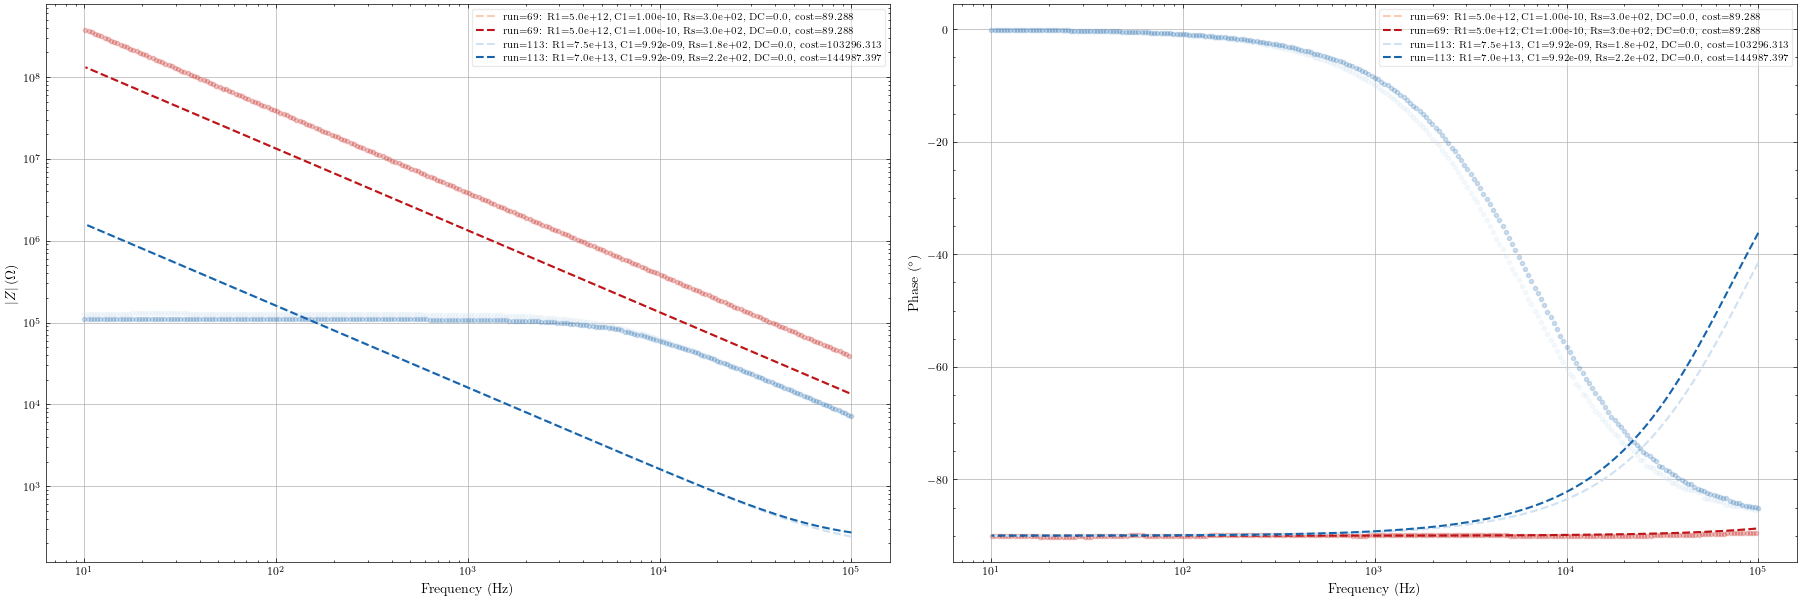

In [27]:
# ---------------------------------------- Plotting the Fitting ------------------------------    

d69  = [[solatron[69][0],solatron[69][0]], [solatron[113][2],solatron[113][6]]]

# Labels
#plot_labels = ['wb6, pristine, ambient', 'wb6, eformed, ambient '] # label for the legend
plot_filename = 'PristineComparisonwkey' # name for exported figure
plot_title = 'Pristine Comparison' # title for powerpoint

# Notes
notes = ['When electroforming, resistance goes from 2e11 to 1e5', 'Capacitance increases from 2e-11 to 2e-10', 'C_siox=5.6e-13','C_pad 1.9e-11', '1nm of TiO2 gives C_tio2 = 2.8e-10' ] # notes for the powerpoint in text box

# if export true, update the plot string
#d113 = update_plot_string(d113, export_data=export_data, plot_labels=plot_labels)

# Plot
fig, ax = IS_plot_fit(d69, d_type='Zabsphi', freq_lim=[1e1, 1e5], y_lim_left=None,
                    sort_data=False,  fig_size=[9,6], med_filt = 11, show_key = True)

# append the figure and title to the list for later exporting
fig_list.append((fig, plot_filename, plot_title, notes)) 

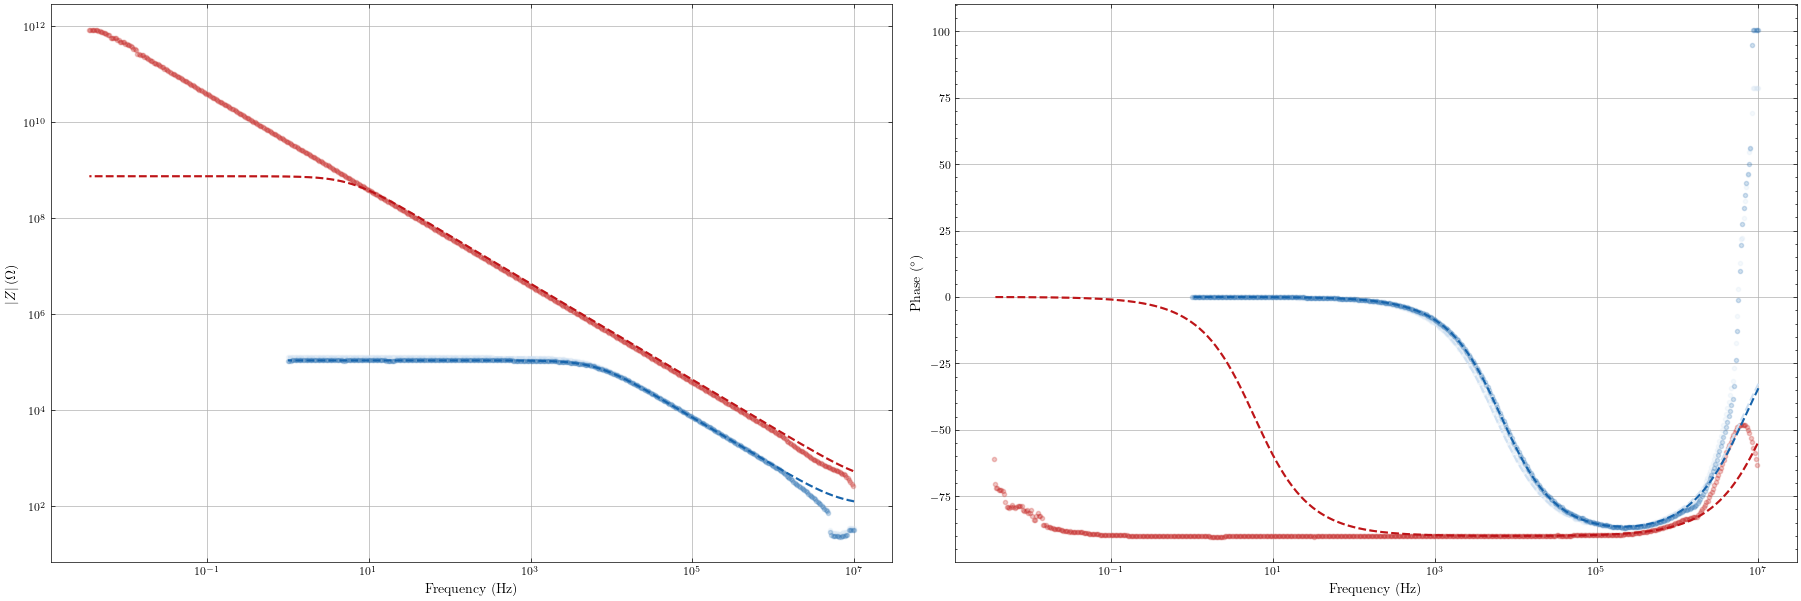

In [7]:
# ---------------------------------------- Plotting the Fitting ------------------------------    

d69  = [[solatron[69][0],solatron[69][0]], [solatron[113][2],solatron[113][6]]]

# Labels
#plot_labels = ['wb6, pristine, ambient', 'wb6, eformed, ambient '] # label for the legend
plot_filename = 'PristineComparisonnokey' # name for exported figure
plot_title = 'Pristine Comparison' # title for powerpoint

# Notes
notes = ['When electroforming, resistance goes from 2e11 to 1e5', 'Capacitance increases from 2e-11 to 2e-10', 'C_siox=5.6e-13','C_pad 1.9e-11', '1nm of TiO2 gives C_tio2 = 2.8e-10' ] # notes for the powerpoint in text box

# if export true, update the plot string
#d113 = update_plot_string(d113, export_data=export_data, plot_labels=plot_labels)

# Plot
fig, ax = IS_plot_fit(d69, d_type='Zabsphi', freq_lim=[1e-3, 1e7], y_lim_left=None,
                    sort_data=False,  fig_size=fig_size, med_filt = 9, show_key = False)

# append the figure and title to the list for later exporting
fig_list.append((fig, plot_filename, plot_title, notes)) 

# All Data

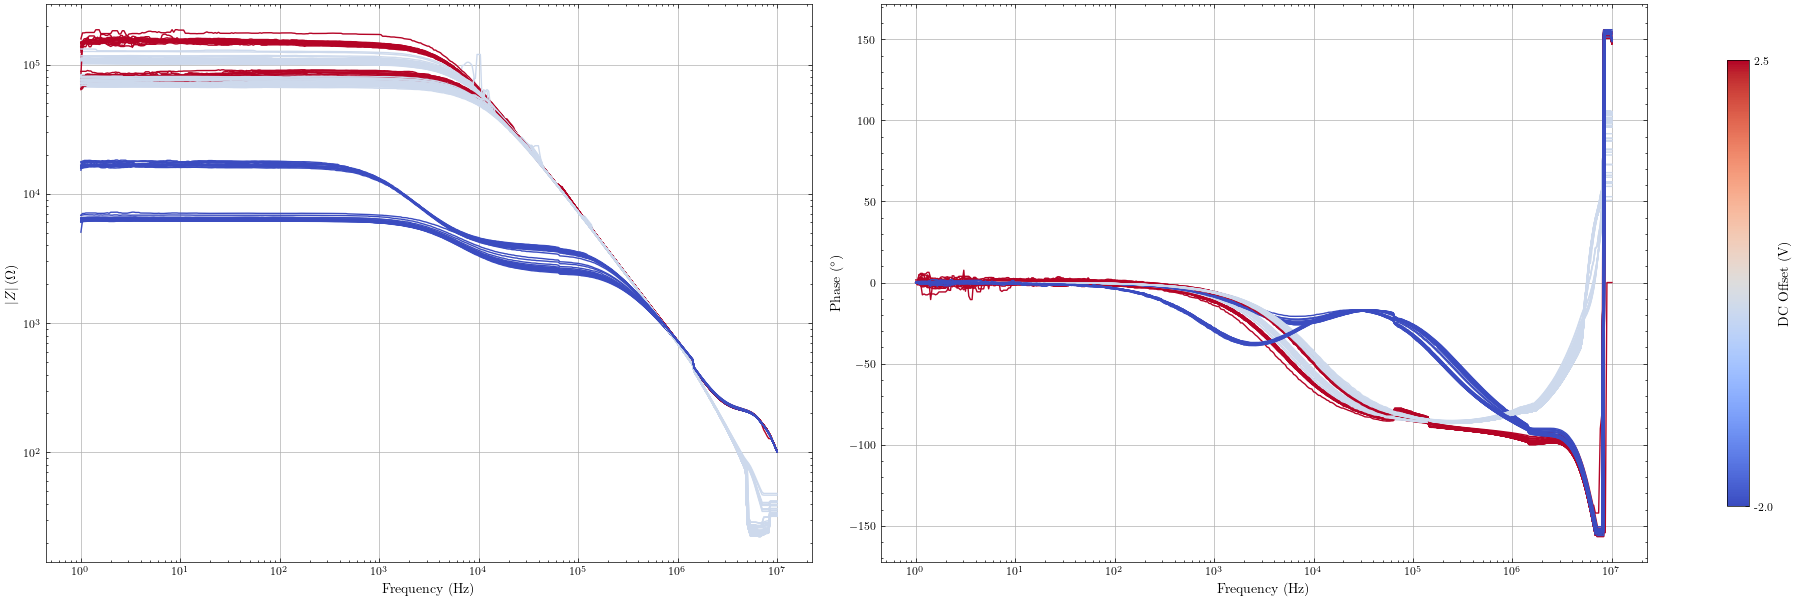

In [8]:
# Select data 
# ---------------------------------------- Plotting the Fitting ------------------------------
# Section off the Vacuum Data
d_vac_set_test = solatron[113][0::4]
d_vac_reset = solatron[113][1::4]
d_vac_reset_test = solatron[113][2::4]
d_vac_set = solatron[113][3::4]

# Section off the Ambient Data
d_amb_set_test = solatron[115][0::4]
d_amb_reset = solatron[115][1::4]
d_amb_reset_test = solatron[115][2::4]
d_amb_set = solatron[115][3::4]
    
d = [d_vac_set_test[1:]+ d_vac_reset+ d_vac_reset_test+ d_vac_set+ d_amb_set_test+ d_amb_reset+ d_amb_reset_test+ d_amb_set]
# extract a single DC level from the data
#d = extract_single_dc(d, DC_val=0)

# Labels
#plot_labels = ['wb5, formed, vacuum', 'wb5, formed, ambient-failed', 'wb5, formed, ambient'] # label for the legend
plot_filename = 'AmbientVacuumOverall' # name for exported figure
plot_title = 'Switching Device with DC Offset in Vacuum and Ambient' # title for powerpoint

# Notes
notes = ['All runs use a loop [0, 2.5V, 0, -2V] to measure state then switch ON/OFF then measure state'
        'Vacuum was left at 9e-7 for 3 days before starting the run',
         'First ambient run was started after 7 hours at ambient but crashed part way through',
         'Second ambient run was started 2 days after the vacuum and completed successfully',
         ] # notes for the powerpoint in text box

# if export true, update the plot string
#d = update_plot_string(d, export_data=export_data, plot_labels=plot_labels)

# Plot
fig, ax = IS_plot(d, d_type='Zabsphi', freq_lim=[1e-3, 1e7], y_lim_right=None,
                    sort_data=False, c_bar=2, fig_size=fig_size, med_filt = 9, force_key = False, show_key=False)

# append the figure and title to the list for later exporting
fig_list.append((fig, plot_filename, plot_title, notes)) 

# SET STATE

In [9]:
# ------------------------------ Fitting ------------------------------

# --- Settings ---
fit_settings = {
    'model_type': 'RC2', # String: 'RC', 'CPE', 'RC2','CPE2, 'RC3', 'CPE3'
    'freq_bounds': (1e-1, 1e6), # Tuple (min_freq, max_freq) for fitting range. None means no limit.
    'med_filt': 5, # Median filter kernel (or 0/None to skip)
    'fixed_params': {'C_pad': C_calc_pad}, #{'R_mem1': np.float64(254647.25), 'C_mem1': np.float64(1.9379283048750973e-10), 'C_pad': np.float64(1.8206090757078506e-11), 'R_series': np.float64(150.64021259132736)},#None, # Dictionary mapping parameter names (str) to fixed values.
                            # {'C_pad': 1.5e-11}, # Fix C_pad (or None to fit all)
                            #  {'C_pad': 1.2e-11, 'R_mem': 1e8} # Fix two parameters (for RC model)
    
    'use_de': True,  # If True, perform Differential Evolution before Least Squares IF False to use only Least Squares (requires good initial guess).
    'plot_fit': False, # If True, display the Bode plot of the fit after completion.
    'fig_size': fig_size, # Figure size for the plot (None to use default).
    'plot_type': 'Zabsphi', # Plot type: 'Zrealimag' or 'Zabsphi'
    # Optional: Provide specific bounds/guesses if needed - set to None to use defaults.
    'de_bounds_dict': {'R_mem1': (1e2, 1e6), 'C_mem1': (1e-10, 1e-8),'R_mem2': (1e3, 1e4), 'C_mem2': (1e-13, 1e-9), #'C_mem2': (C_calc_siox*0.5, C_calc_siox*1.5),
                     'C_pad': (1e-11, 3e-11), 'R_series': (1, 1e4), 'Q1': (1e-12, 1e-7), 'alpha1': (0.6, 1.0),
                      'Q2': (1e-13, 1e-8), 'alpha2': (0.5, 1.0)}, #'R_mem1': (1e1, 1e14),
    #'ls_bounds_dict': {'R_mem1': (1e-3, np.inf), 'C_mem1': (0, np.inf), 'R_mem2': (1e-3, np.inf), 
                        # 'C_mem2': (0, np.inf), 'C_pad': (0, np.inf), 'R_series': (0, np.inf), 'Q1': (1e-15, np.inf), 
                        # 'alpha1': (1e-3, 1.0), 'Q2': (1e-15, np.inf), 'alpha2': (1e-3, 1.0)}
                        
    # 'initial_guess_dict': {'R_mem1': 5e7, 'C_mem1': 5e-11, 'R_mem2': 1e5, 'C_mem2': 1e-9, 'C_pad': 2e-11, 'R_series': 70.0,
                             # 'Q1': 4e-11, 'alpha1': 0.92, 'Q2': 5e-10, 'alpha2': 0.85}
    'de_maxiter': 6000000, # Max generations (iterations) for Differential Evolution. Increase for complex problems.
    'ls_max_nfev': 300000, # Max function evaluations for Least Squares. Increase if refinement terminates early.
    'de_popsize':50, 
    'de_tol': 1e-5, 
    'ls_ftol':1e-13, 
    'ls_xtol':1e-13, 
    'ls_gtol':1e-13,
}

# Set the bounds for the Least Squares fit to be the same as the Differential Evolution bounds
fit_settings['ls_bounds_dict'] = fit_settings['de_bounds_dict']

# Set Test Data
d_vac_set_test = solatron[113][0::4]
d_amb_set_test = solatron[115][0::4]
# Reset Test Data
d_vac_reset_test = solatron[113][2::4]
d_amb_reset_test = solatron[115][2::4]
# Reset Data
d_vac_reset = solatron[113][1::4]
d_amb_reset = solatron[115][1::4]
# Set data
d_vac_set = solatron[113][3::4]
d_amb_set = solatron[115][3::4]

# --- Select Data ---
# Select data 
d113  = [d_vac_set, d_amb_set]
#[solatron[73][0], solatron[75][0], solatron[77][0], solatron[80][0], solatron[82][0], solatron[84][0], solatron[91][0], solatron[92][0], solatron[93][0], solatron[95][0], solatron[98][0] ]

# extract a single DC level from the data
#dfit = extract_single_dc(dfit, DC_val=0)
for section in d113:
    for dat in section:
        # --- Run Fit ---
        fig, ax = fit_impedance_data(dat, **fit_settings)





--- Starting Fit for: run=113, DC=-2.0, V_rms=0.01, p, vacuum, amp, wirebond5 ---
Using model: RC2
With fixed params: {'C_pad': 1.9147705850766482e-11}
Frequency range: (0.1, 1000000.0)
Free parameters to fit: ['R_mem1', 'C_mem1', 'R_mem2', 'C_mem2', 'R_series']
361 pts post-freq filter.
Median filter k=5
Running DE...
DE OK.
 DE Final Cost: 4.1045e-01
  DE Best:)
name R_mem1: 3.56e+03
name C_mem1: 1.00e-08
name R_mem2: 3.50e+03
name C_mem2: 2.36e-10
name R_series: 1.00e+00

Running LS Refinement...
LS OK!
  LS Final Cost: 0.210
  Final Fitted Parameters:
    R_mem1: 3559.657
    C_mem1: 0.000
    R_mem2: 3502.235
    C_mem2: 0.000
    C_pad: 0.000
    R_series: 1.000
--- Fit finished for: run=113, DC=-2.0, V_rms=0.01, p, vacuum, amp, wirebond5 ---

--- Starting Fit for: run=113, DC=-2.0, V_rms=0.01, p, vacuum, amp, wirebond5 ---
Using model: RC2
With fixed params: {'C_pad': 1.9147705850766482e-11}
Frequency range: (0.1, 1000000.0)
Free parameters to fit: ['R_mem1', 'C_mem1', 'R_mem2'

### SET - vac v amb

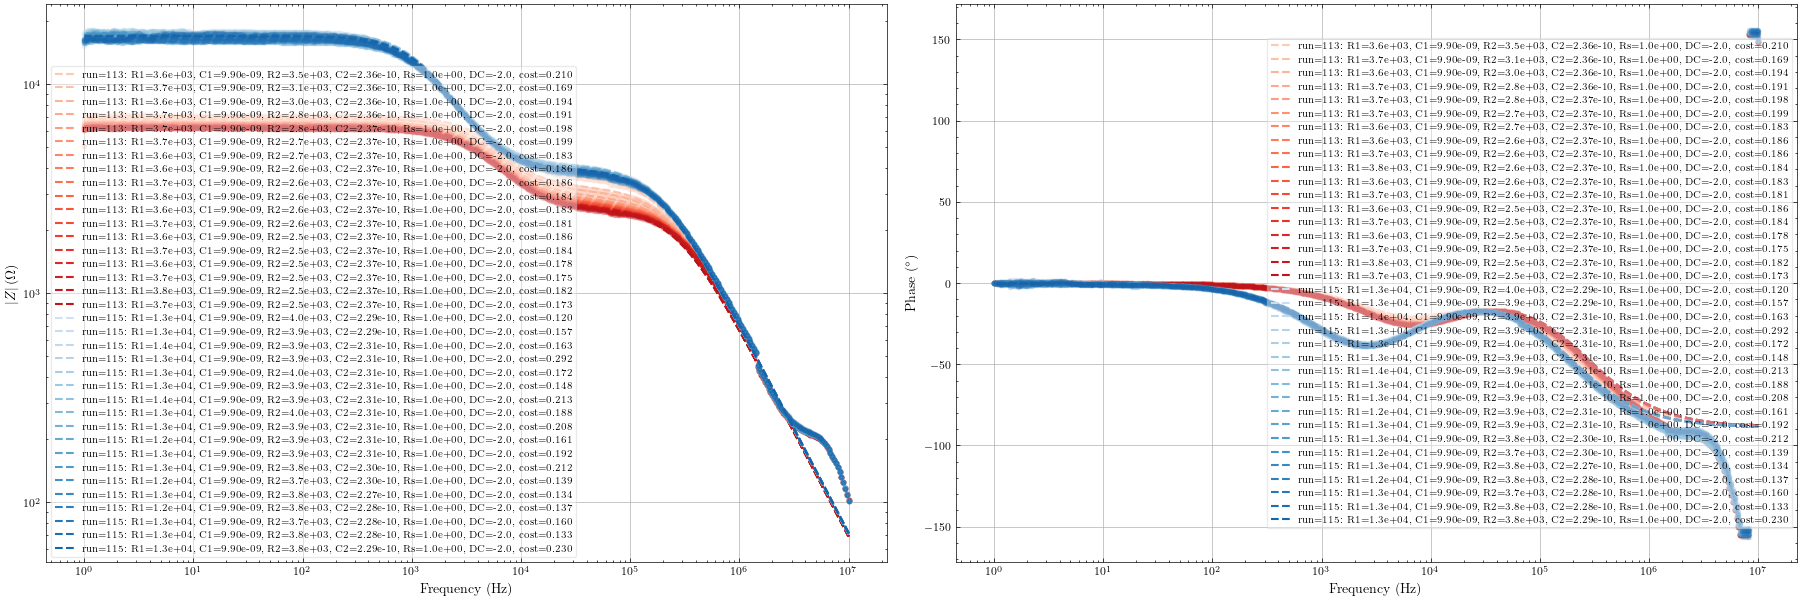

In [10]:
# ---------------------------------------- Plotting the Fitting ------------------------------
# Set Test Data
d_vac_set_test = solatron[113][0::4]
d_amb_set_test = solatron[115][0::4]
# Reset Test Data
d_vac_reset_test = solatron[113][2::4]
d_amb_reset_test = solatron[115][2::4]
# Reset Data
d_vac_reset = solatron[113][1::4]
d_amb_reset = solatron[115][1::4]
# Set data
d_vac_set = solatron[113][3::4]
d_amb_set = solatron[115][3::4]
    

d113 = [d_vac_set, d_amb_set] #

# Labels
#plot_labels = ['wb6, pristine, ambient', 'wb6, eformed, ambient '] # label for the legend
plot_filename = 'dcsetambvacwithkey' # name for exported figure
plot_title = 'DC = -2V Ambient vs Vacuum with Key' # title for powerpoint

# Notes
notes = ['vacuum in red, ambient in blue', 'C1 of 10nA is unphysical yet clearly present', 'C2 of 2e-10 fits with the thin TiO2'
         'gives a permittivity of 60k for 25nm and 2k for 1nm.', 'small shift in only C2 not C1 from ambient to vacuum', 'significant shifts in R1/R2 from ambient to vacuum'] # notes for the powerpoint in text box

# if export true, update the plot string
#d113 = update_plot_string(d113, export_data=export_data, plot_labels=plot_labels)

# Plot
fig, ax = IS_plot_fit(d113, d_type='Zabsphi', freq_lim=[1e-3, 1e7], y_lim_left=None,
                    sort_data=False,  fig_size=[9, 6], med_filt = 9, show_key = True)

# append the figure and title to the list for later exporting
fig_list.append((fig, plot_filename, plot_title, notes)) 

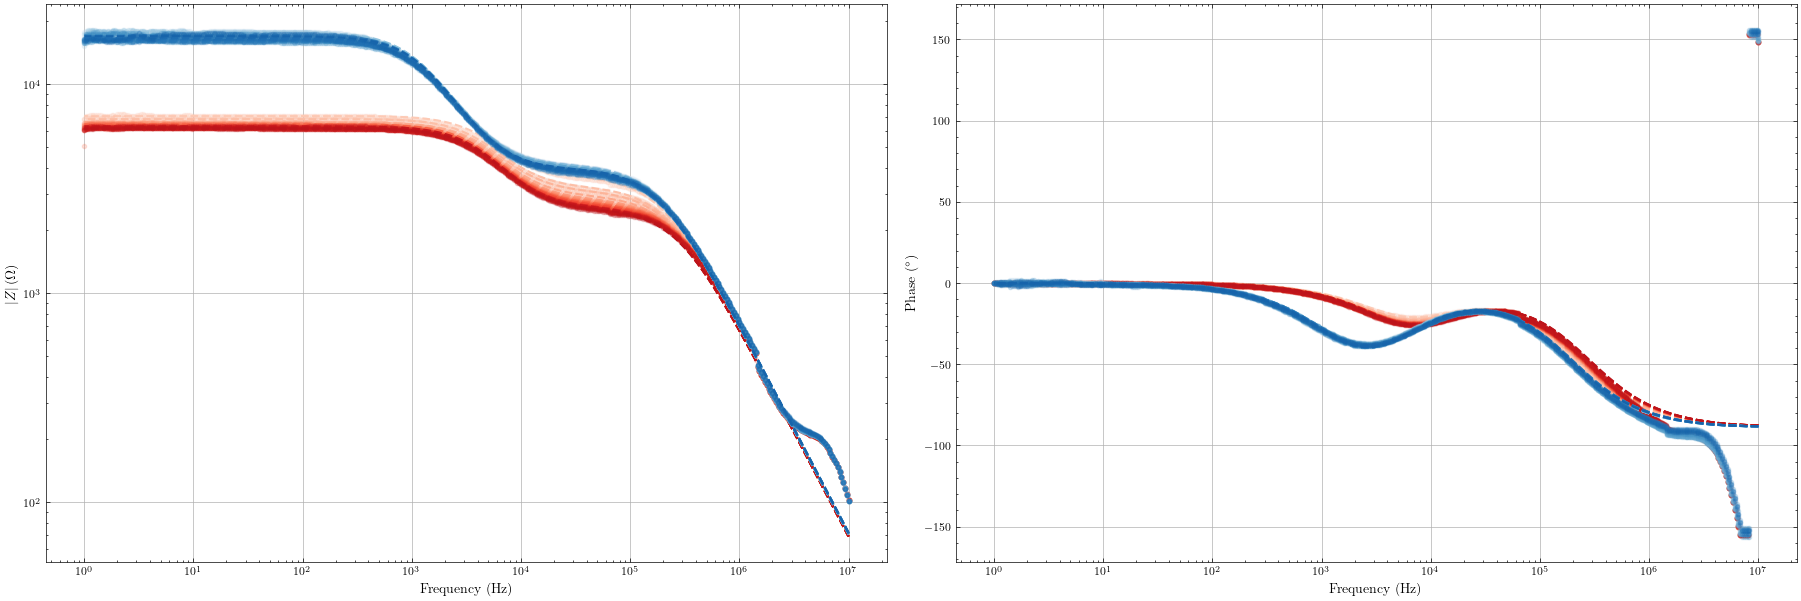

In [11]:

d113 = [d_vac_set, d_amb_set] #

# Labels
#plot_labels = ['wb6, pristine, ambient', 'wb6, eformed, ambient '] # label for the legend
plot_filename = 'dcsetambvacnokey' # name for exported figure
plot_title = 'DC = -2V Ambient vs Vacuum with Key' # title for powerpoint

# Notes
notes = ['vacuum in red, ambient in blue', 'C1 of 10nA is unphysical yet clearly present', 'C2 of 2e-10 fits with the thin TiO2'
         'gives a permittivity of 60k for 25nm and 2k for 1nm.', 'small shift in only C2 not C1 from ambient to vacuum', 'significant shifts in R1/R2 from ambient to vacuum'] # notes for the powerpoint in text box

# if export true, update the plot string
#d113 = update_plot_string(d113, export_data=export_data, plot_labels=plot_labels)

# Plot
fig, ax = IS_plot_fit(d113, d_type='Zabsphi', freq_lim=[1e-3, 1e7], y_lim_left=None,
                    sort_data=False,  fig_size=fig_size, med_filt = 9, show_key = False)

# append the figure and title to the list for later exporting
fig_list.append((fig, plot_filename, plot_title, notes)) 

# Set TEST

In [12]:
# ------------------------------ Fitting ------------------------------

# --- Settings ---
fit_settings = {
    'model_type': 'RC', # String: 'RC', 'CPE', 'RC2','CPE2, 'RC3', 'CPE3'
    'freq_bounds': (1e-1, 1e6), # Tuple (min_freq, max_freq) for fitting range. None means no limit.
    'med_filt': 5, # Median filter kernel (or 0/None to skip)
    'fixed_params': {'C_pad': C_calc_pad}, #{'R_mem1': np.float64(254647.25), 'C_mem1': np.float64(1.9379283048750973e-10), 'C_pad': np.float64(1.8206090757078506e-11), 'R_series': np.float64(150.64021259132736)},#None, # Dictionary mapping parameter names (str) to fixed values.
                            # {'C_pad': 1.5e-11}, # Fix C_pad (or None to fit all)
                            #  {'C_pad': 1.2e-11, 'R_mem': 1e8} # Fix two parameters (for RC model)
    
    'use_de': True,  # If True, perform Differential Evolution before Least Squares IF False to use only Least Squares (requires good initial guess).
    'plot_fit': False, # If True, display the Bode plot of the fit after completion.
    'fig_size': fig_size, # Figure size for the plot (None to use default).
    'plot_type': 'Zabsphi', # Plot type: 'Zrealimag' or 'Zabsphi'
    # Optional: Provide specific bounds/guesses if needed - set to None to use defaults.
    'de_bounds_dict': {'R_mem1': (1e2, 1e6), 'C_mem1': (1e-10, 1e-8),'R_mem2': (1e3, 1e4), 'C_mem2': (1e-13, 1e-9), #'C_mem2': (C_calc_siox*0.5, C_calc_siox*1.5),
                     'C_pad': (1e-11, 3e-11), 'R_series': (1, 1e4), 'Q1': (1e-12, 1e-7), 'alpha1': (0.6, 1.0),
                      'Q2': (1e-13, 1e-8), 'alpha2': (0.5, 1.0)}, #'R_mem1': (1e1, 1e14),
    #'ls_bounds_dict': {'R_mem1': (1e-3, np.inf), 'C_mem1': (0, np.inf), 'R_mem2': (1e-3, np.inf), 
                        # 'C_mem2': (0, np.inf), 'C_pad': (0, np.inf), 'R_series': (0, np.inf), 'Q1': (1e-15, np.inf), 
                        # 'alpha1': (1e-3, 1.0), 'Q2': (1e-15, np.inf), 'alpha2': (1e-3, 1.0)}
                        
    # 'initial_guess_dict': {'R_mem1': 5e7, 'C_mem1': 5e-11, 'R_mem2': 1e5, 'C_mem2': 1e-9, 'C_pad': 2e-11, 'R_series': 70.0,
                             # 'Q1': 4e-11, 'alpha1': 0.92, 'Q2': 5e-10, 'alpha2': 0.85}
    'de_maxiter': 6000000, # Max generations (iterations) for Differential Evolution. Increase for complex problems.
    'ls_max_nfev': 300000, # Max function evaluations for Least Squares. Increase if refinement terminates early.
    'de_popsize':50, 
    'de_tol': 1e-5, 
    'ls_ftol':1e-13, 
    'ls_xtol':1e-13, 
    'ls_gtol':1e-13,
}

# Set the bounds for the Least Squares fit to be the same as the Differential Evolution bounds
fit_settings['ls_bounds_dict'] = fit_settings['de_bounds_dict']

# Set Test Data
d_vac_set_test = solatron[113][0::4]
d_amb_set_test = solatron[115][0::4]
# Reset Test Data
d_vac_reset_test = solatron[113][2::4]
d_amb_reset_test = solatron[115][2::4]
# Reset Data
d_vac_reset = solatron[113][1::4]
d_amb_reset = solatron[115][1::4]
# Set data
d_vac_set = solatron[113][3::4]
d_amb_set = solatron[115][3::4]

# --- Select Data ---
# Select data 
d113  = [d_vac_set_test, d_amb_set_test]
#[solatron[73][0], solatron[75][0], solatron[77][0], solatron[80][0], solatron[82][0], solatron[84][0], solatron[91][0], solatron[92][0], solatron[93][0], solatron[95][0], solatron[98][0] ]

# extract a single DC level from the data
#dfit = extract_single_dc(dfit, DC_val=0)
for section in d113:
    for dat in section:
        # --- Run Fit ---
        fig, ax = fit_impedance_data(dat, **fit_settings)





--- Starting Fit for: run=113, DC=0.0, V_rms=0.01, p, vacuum, amp, wirebond5 ---
Using model: RC
With fixed params: {'C_pad': 1.9147705850766482e-11}
Frequency range: (0.1, 1000000.0)
Free parameters to fit: ['R_mem1', 'C_mem1', 'R_series']
361 pts post-freq filter.
Median filter k=5
Running DE...
DE OK.
 DE Final Cost: 1.4887e+02
  DE Best:)
name R_mem1: 4.60e+05
name C_mem1: 1.00e-10
name R_series: 1.00e+04

Running LS Refinement...
LS OK!
  LS Final Cost: 74.435
  Final Fitted Parameters:
    R_mem1: 459993.566
    C_mem1: 0.000
    C_pad: 0.000
    R_series: 10000.000
--- Fit finished for: run=113, DC=0.0, V_rms=0.01, p, vacuum, amp, wirebond5 ---

--- Starting Fit for: run=113, DC=0.0, V_rms=0.01, p, vacuum, amp, wirebond5 ---
Using model: RC
With fixed params: {'C_pad': 1.9147705850766482e-11}
Frequency range: (0.1, 1000000.0)
Free parameters to fit: ['R_mem1', 'C_mem1', 'R_series']
361 pts post-freq filter.
Median filter k=5
Running DE...
DE OK.
 DE Final Cost: 6.8045e-02
  DE 

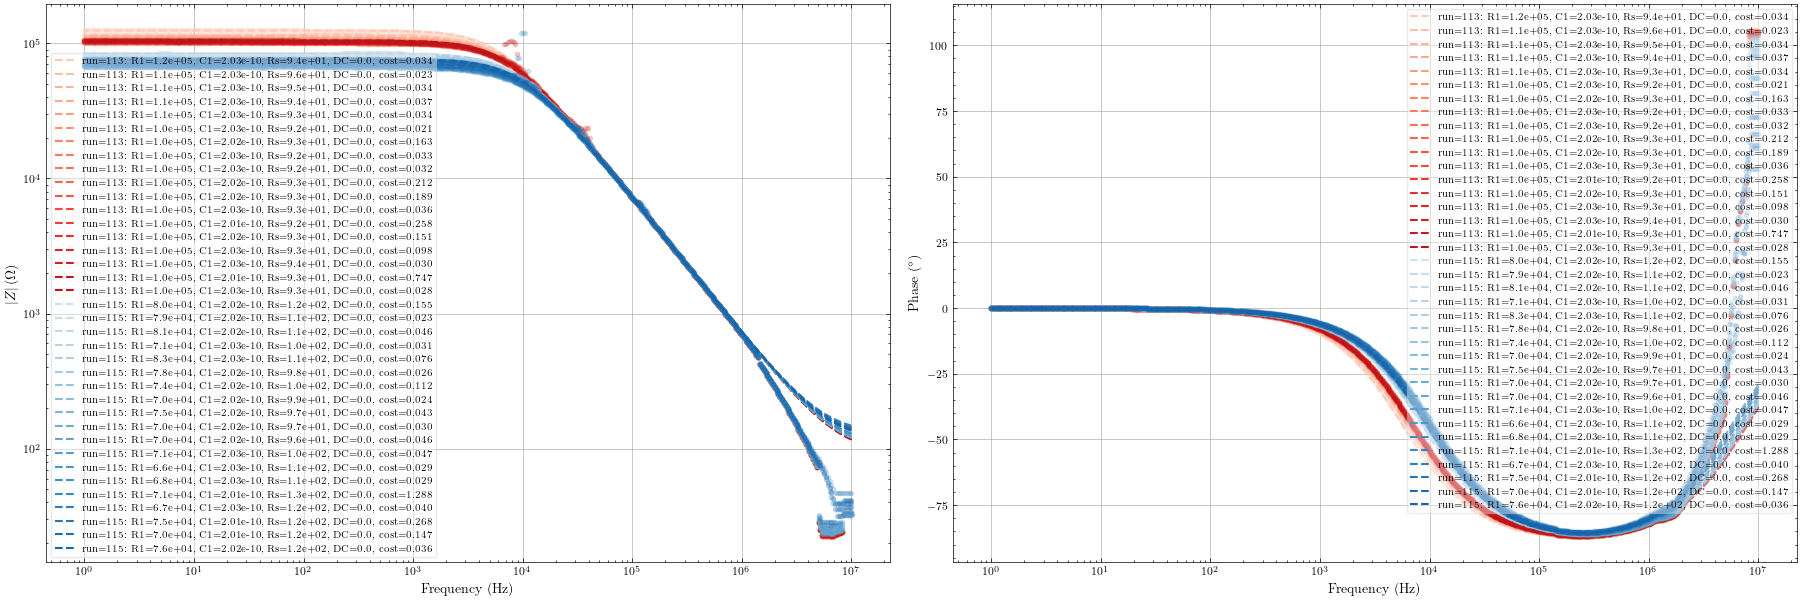

In [13]:
# ---------------------------------------- Plotting the Fitting ------------------------------
# Set Test Data
d_vac_set_test = solatron[113][0::4]
d_amb_set_test = solatron[115][0::4]
# Reset Test Data
d_vac_reset_test = solatron[113][2::4]
d_amb_reset_test = solatron[115][2::4]
# Reset Data
d_vac_reset = solatron[113][1::4]
d_amb_reset = solatron[115][1::4]
# Set data
d_vac_set = solatron[113][3::4]
d_amb_set = solatron[115][3::4]
    

d113 = [d_vac_set_test[1:], d_amb_set_test]

# Labels
#plot_labels = ['wb6, pristine, ambient', 'wb6, eformed, ambient '] # label for the legend
plot_filename = 'dcsettestambvacwithkey' # name for exported figure
plot_title = 'DC = 0V, post SET(-2V) Ambient vs Vacuum with Key' # title for powerpoint

# Notes
notes = ['vacuum in red, ambient in blue', 'single RC model', 'Lower resistivity in ambient', 'Very similar capacitance for both'] # notes for the powerpoint in text box

# if export true, update the plot string
#d113 = update_plot_string(d113, export_data=export_data, plot_labels=plot_labels)

# Plot
fig, ax = IS_plot_fit(d113, d_type='Zabsphi', freq_lim=[1e-3, 1e7], y_lim_left=None,
                    sort_data=False,  fig_size=[9, 6], med_filt = 9, show_key = True)

# append the figure and title to the list for later exporting
fig_list.append((fig, plot_filename, plot_title, notes)) 

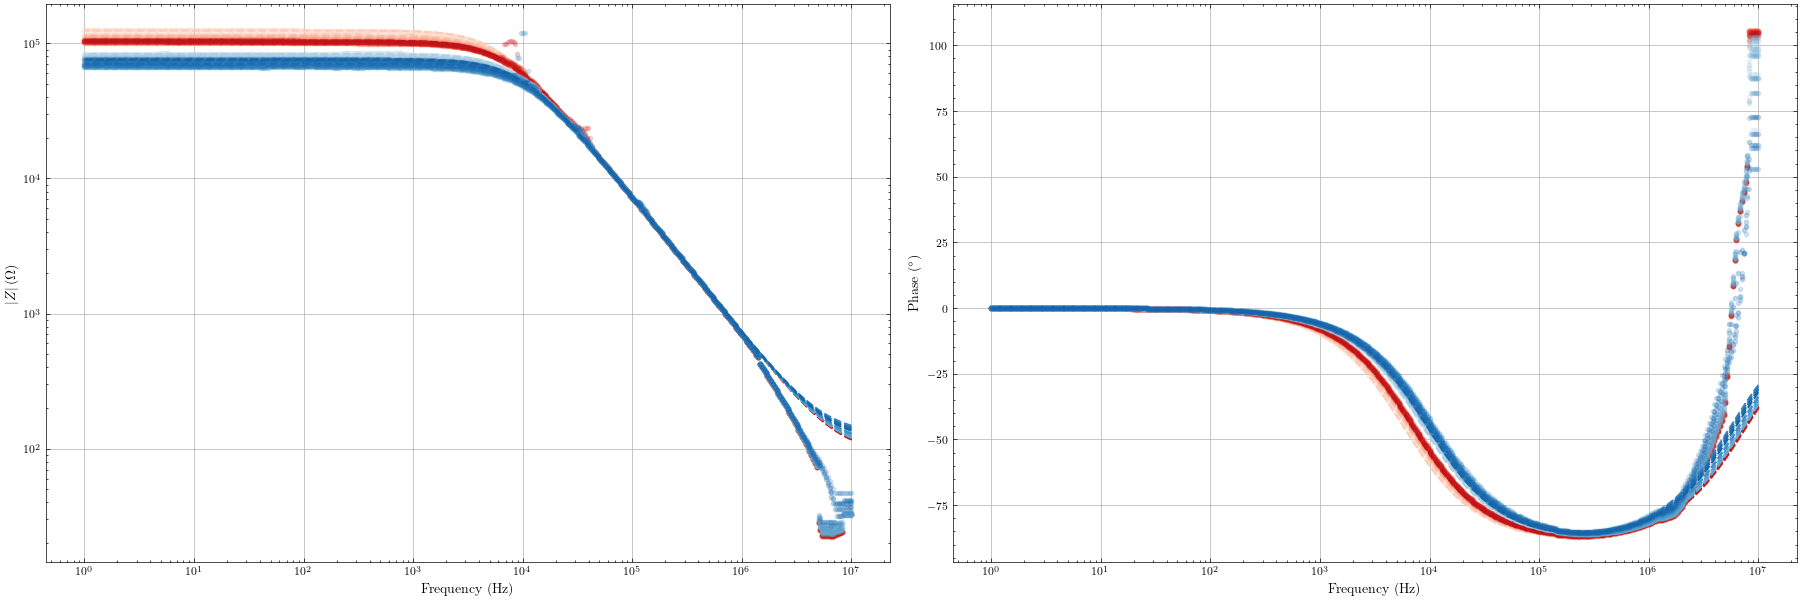

In [14]:
# ---------------------------------------- Plotting the Fitting ------------------------------
# Set Test Data
d_vac_set_test = solatron[113][0::4]
d_amb_set_test = solatron[115][0::4]
# Reset Test Data
d_vac_reset_test = solatron[113][2::4]
d_amb_reset_test = solatron[115][2::4]
# Reset Data
d_vac_reset = solatron[113][1::4]
d_amb_reset = solatron[115][1::4]
# Set data
d_vac_set = solatron[113][3::4]
d_amb_set = solatron[115][3::4]
    

d113 = [d_vac_set_test[1:], d_amb_set_test]

# Labels
#plot_labels = ['wb6, pristine, ambient', 'wb6, eformed, ambient '] # label for the legend
plot_filename = 'dcsettestambvacnokey' # name for exported figure
plot_title = 'DC = 0V, post SET(-2V) Ambient vs Vacuum without Key' # title for powerpoint

# Notes
notes = ['vacuum in red, ambient in blue', 'single RC model', 'Lower resistivity in ambient', 'Very similar capacitance for both'] # notes for the powerpoint in text box

# if export true, update the plot string
#d113 = update_plot_string(d113, export_data=export_data, plot_labels=plot_labels)

# Plot
fig, ax = IS_plot_fit(d113, d_type='Zabsphi', freq_lim=[1e-3, 1e7], y_lim_left=None,
                    sort_data=False,  fig_size=fig_size, med_filt = 9, show_key = False)

# append the figure and title to the list for later exporting
fig_list.append((fig, plot_filename, plot_title, notes)) 

# RESET

In [15]:
# ------------------------------ Fitting ------------------------------

# --- Settings ---
fit_settings = {
    'model_type': 'RC', # String: 'RC', 'CPE', 'RC2','CPE2, 'RC3', 'CPE3'
    'freq_bounds': (1e-1, 1e6), # Tuple (min_freq, max_freq) for fitting range. None means no limit.
    'med_filt': 5, # Median filter kernel (or 0/None to skip)
    'fixed_params': {'C_pad': C_calc_pad}, #{'R_mem1': np.float64(254647.25), 'C_mem1': np.float64(1.9379283048750973e-10), 'C_pad': np.float64(1.8206090757078506e-11), 'R_series': np.float64(150.64021259132736)},#None, # Dictionary mapping parameter names (str) to fixed values.
                            # {'C_pad': 1.5e-11}, # Fix C_pad (or None to fit all)
                            #  {'C_pad': 1.2e-11, 'R_mem': 1e8} # Fix two parameters (for RC model)
    
    'use_de': True,  # If True, perform Differential Evolution before Least Squares IF False to use only Least Squares (requires good initial guess).
    'plot_fit': False, # If True, display the Bode plot of the fit after completion.
    'fig_size': fig_size, # Figure size for the plot (None to use default).
    'plot_type': 'Zabsphi', # Plot type: 'Zrealimag' or 'Zabsphi'
    # Optional: Provide specific bounds/guesses if needed - set to None to use defaults.
    'de_bounds_dict': {'R_mem1': (1e2, 1e6), 'C_mem1': (1e-10, 1e-8),'R_mem2': (1e3, 1e4), 'C_mem2': (1e-13, 1e-9), #'C_mem2': (C_calc_siox*0.5, C_calc_siox*1.5),
                     'C_pad': (1e-11, 3e-11), 'R_series': (1, 1e4), 'Q1': (1e-12, 1e-7), 'alpha1': (0.6, 1.0),
                      'Q2': (1e-13, 1e-8), 'alpha2': (0.5, 1.0)}, #'R_mem1': (1e1, 1e14),
    #'ls_bounds_dict': {'R_mem1': (1e-3, np.inf), 'C_mem1': (0, np.inf), 'R_mem2': (1e-3, np.inf), 
                        # 'C_mem2': (0, np.inf), 'C_pad': (0, np.inf), 'R_series': (0, np.inf), 'Q1': (1e-15, np.inf), 
                        # 'alpha1': (1e-3, 1.0), 'Q2': (1e-15, np.inf), 'alpha2': (1e-3, 1.0)}
                        
    # 'initial_guess_dict': {'R_mem1': 5e7, 'C_mem1': 5e-11, 'R_mem2': 1e5, 'C_mem2': 1e-9, 'C_pad': 2e-11, 'R_series': 70.0,
                             # 'Q1': 4e-11, 'alpha1': 0.92, 'Q2': 5e-10, 'alpha2': 0.85}
    'de_maxiter': 6000000, # Max generations (iterations) for Differential Evolution. Increase for complex problems.
    'ls_max_nfev': 300000, # Max function evaluations for Least Squares. Increase if refinement terminates early.
    'de_popsize':50, 
    'de_tol': 1e-5, 
    'ls_ftol':1e-13, 
    'ls_xtol':1e-13, 
    'ls_gtol':1e-13,
}

# Set the bounds for the Least Squares fit to be the same as the Differential Evolution bounds
fit_settings['ls_bounds_dict'] = fit_settings['de_bounds_dict']

# Set Test Data
d_vac_set_test = solatron[113][0::4]
d_amb_set_test = solatron[115][0::4]
# Reset Test Data
d_vac_reset_test = solatron[113][2::4]
d_amb_reset_test = solatron[115][2::4]
# Reset Data
d_vac_reset = solatron[113][1::4]
d_amb_reset = solatron[115][1::4]
# Set data
d_vac_set = solatron[113][3::4]
d_amb_set = solatron[115][3::4]

# --- Select Data ---
# Select data 
d113  = [d_vac_reset, d_amb_reset]
#[solatron[73][0], solatron[75][0], solatron[77][0], solatron[80][0], solatron[82][0], solatron[84][0], solatron[91][0], solatron[92][0], solatron[93][0], solatron[95][0], solatron[98][0] ]

# extract a single DC level from the data
#dfit = extract_single_dc(dfit, DC_val=0)
for section in d113:
    for dat in section:
        # --- Run Fit ---
        fig, ax = fit_impedance_data(dat, **fit_settings)





--- Starting Fit for: run=113, DC=2.5, V_rms=0.01, p, vacuum, amp, wirebond5 ---
Using model: RC
With fixed params: {'C_pad': 1.9147705850766482e-11}
Frequency range: (0.1, 1000000.0)
Free parameters to fit: ['R_mem1', 'C_mem1', 'R_series']
361 pts post-freq filter.
Median filter k=5
Running DE...
DE OK.
 DE Final Cost: 4.2713e-01
  DE Best:)
name R_mem1: 1.75e+05
name C_mem1: 2.01e-10
name R_series: 1.00e+00

Running LS Refinement...
LS OK!
  LS Final Cost: 0.214
  Final Fitted Parameters:
    R_mem1: 175037.424
    C_mem1: 0.000
    C_pad: 0.000
    R_series: 1.000
--- Fit finished for: run=113, DC=2.5, V_rms=0.01, p, vacuum, amp, wirebond5 ---

--- Starting Fit for: run=113, DC=2.5, V_rms=0.01, p, vacuum, amp, wirebond5 ---
Using model: RC
With fixed params: {'C_pad': 1.9147705850766482e-11}
Frequency range: (0.1, 1000000.0)
Free parameters to fit: ['R_mem1', 'C_mem1', 'R_series']
361 pts post-freq filter.
Median filter k=5
Running DE...
DE OK.
 DE Final Cost: 4.9596e-01
  DE Best:

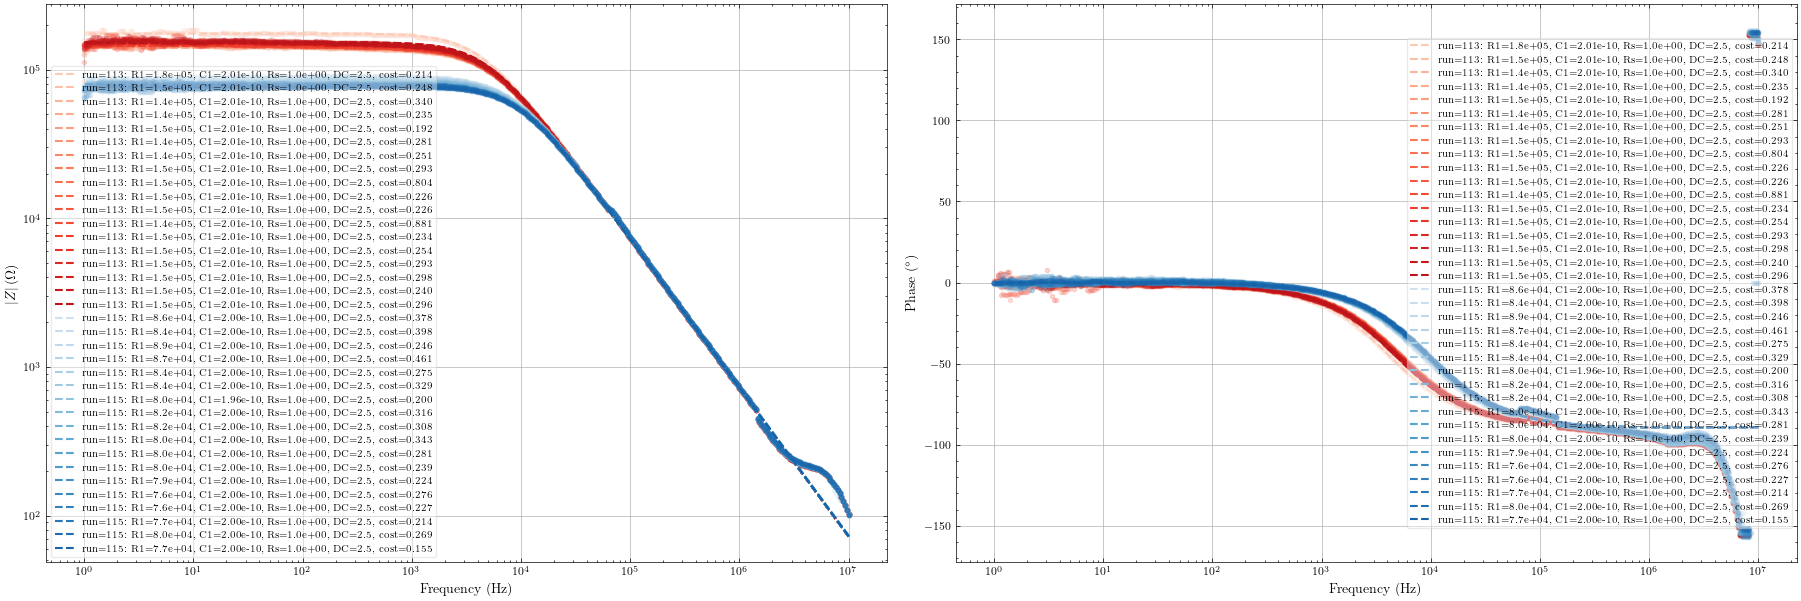

In [16]:
# ---------------------------------------- Plotting the Fitting ------------------------------
# Set Test Data
d_vac_set_test = solatron[113][0::4]
d_amb_set_test = solatron[115][0::4]
# Reset Test Data
d_vac_reset_test = solatron[113][2::4]
d_amb_reset_test = solatron[115][2::4]
# Reset Data
d_vac_reset = solatron[113][1::4]
d_amb_reset = solatron[115][1::4]
# Set data
d_vac_set = solatron[113][3::4]
d_amb_set = solatron[115][3::4]
    

d113 = [d_vac_reset, d_amb_reset]

# Labels
#plot_labels = ['wb6, pristine, ambient', 'wb6, eformed, ambient '] # label for the legend
plot_filename = 'dcresetambvackey' # name for exported figure
plot_title = 'DC = 2.5V Ambient vs Vacuum' # title for powerpoint

# Notes
notes = ['vacuum in red, ambient in blue', 'Lower resistivity in ambient', 'Very slightly lower capacitance in ambient' ] # notes for the powerpoint in text box

# if export true, update the plot string
#d113 = update_plot_string(d113, export_data=export_data, plot_labels=plot_labels)

# Plot
fig, ax = IS_plot_fit(d113, d_type='Zabsphi', freq_lim=[1e-3, 1e7], y_lim_left=None,
                    sort_data=False,  fig_size=[9, 6], med_filt = 9, show_key = True)

# append the figure and title to the list for later exporting
fig_list.append((fig, plot_filename, plot_title, notes)) 

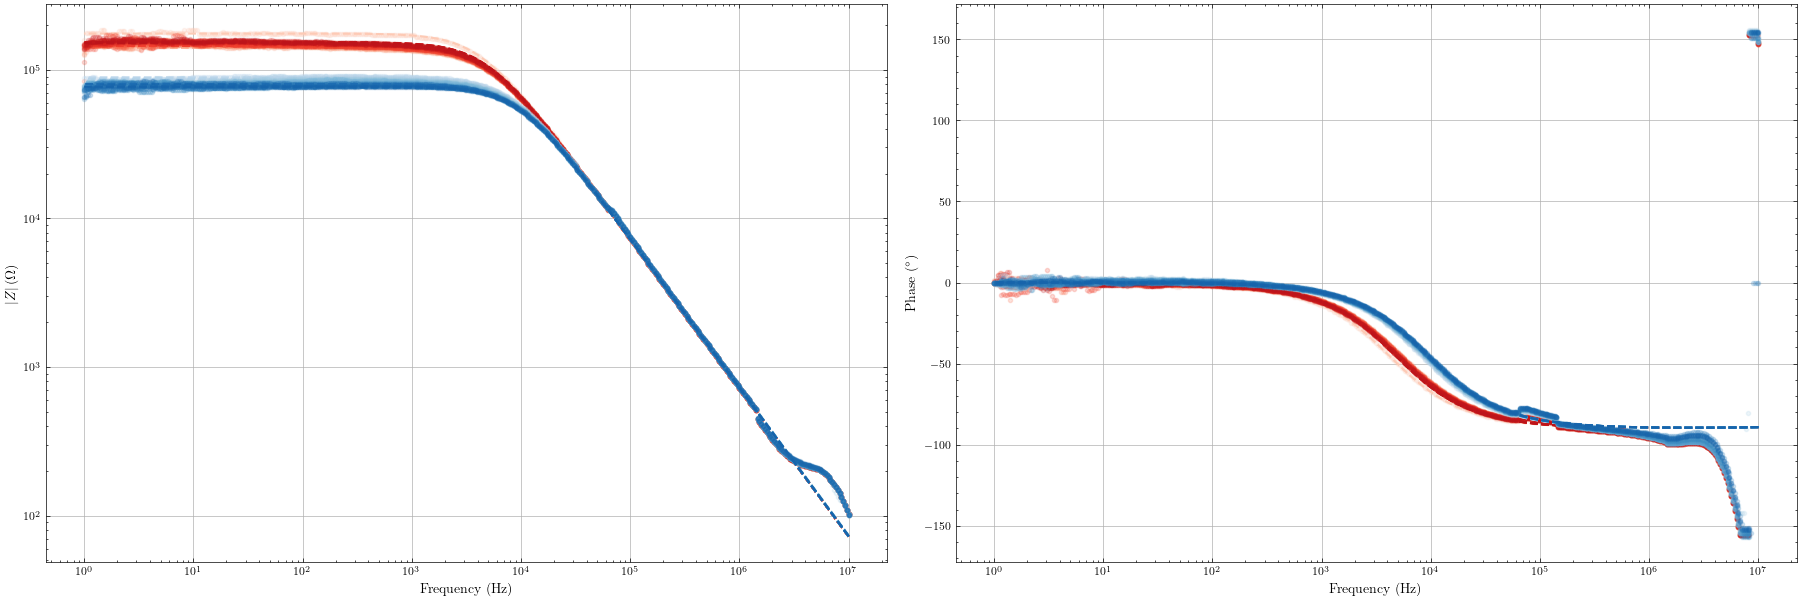

In [17]:
# ---------------------------------------- Plotting the Fitting ------------------------------
# Set Test Data
d_vac_set_test = solatron[113][0::4]
d_amb_set_test = solatron[115][0::4]
# Reset Test Data
d_vac_reset_test = solatron[113][2::4]
d_amb_reset_test = solatron[115][2::4]
# Reset Data
d_vac_reset = solatron[113][1::4]
d_amb_reset = solatron[115][1::4]
# Set data
d_vac_set = solatron[113][3::4]
d_amb_set = solatron[115][3::4]
    

d113 = [d_vac_reset, d_amb_reset]

# Labels
#plot_labels = ['wb6, pristine, ambient', 'wb6, eformed, ambient '] # label for the legend
plot_filename = 'dcresetambvackeynokey' # name for exported figure
plot_title = 'DC = 2.5V Ambient vs Vacuum' # title for powerpoint

# Notes
notes = ['vacuum in red, ambient in blue', 'Lower resistivity in ambient', 'Very slightly lower capacitance in ambient' ] # notes for the powerpoint in text box

# if export true, update the plot string
#d113 = update_plot_string(d113, export_data=export_data, plot_labels=plot_labels)

# Plot
fig, ax = IS_plot_fit(d113, d_type='Zabsphi', freq_lim=[1e-3, 1e7], y_lim_left=None,
                    sort_data=False,  fig_size=fig_size, med_filt = 9, show_key = False)

# append the figure and title to the list for later exporting
fig_list.append((fig, plot_filename, plot_title, notes)) 

# RESET TEST

In [18]:
# ------------------------------ Fitting ------------------------------

# --- Settings ---
fit_settings = {
    'model_type': 'RC', # String: 'RC', 'CPE', 'RC2','CPE2, 'RC3', 'CPE3'
    'freq_bounds': (1e-1, 1e6), # Tuple (min_freq, max_freq) for fitting range. None means no limit.
    'med_filt': 5, # Median filter kernel (or 0/None to skip)
    'fixed_params': {'C_pad': C_calc_pad}, #{'R_mem1': np.float64(254647.25), 'C_mem1': np.float64(1.9379283048750973e-10), 'C_pad': np.float64(1.8206090757078506e-11), 'R_series': np.float64(150.64021259132736)},#None, # Dictionary mapping parameter names (str) to fixed values.
                            # {'C_pad': 1.5e-11}, # Fix C_pad (or None to fit all)
                            #  {'C_pad': 1.2e-11, 'R_mem': 1e8} # Fix two parameters (for RC model)
    
    'use_de': True,  # If True, perform Differential Evolution before Least Squares IF False to use only Least Squares (requires good initial guess).
    'plot_fit': False, # If True, display the Bode plot of the fit after completion.
    'fig_size': fig_size, # Figure size for the plot (None to use default).
    'plot_type': 'Zabsphi', # Plot type: 'Zrealimag' or 'Zabsphi'
    # Optional: Provide specific bounds/guesses if needed - set to None to use defaults.
    'de_bounds_dict': {'R_mem1': (1e2, 1e6), 'C_mem1': (1e-10, 1e-8),'R_mem2': (1e3, 1e4), 'C_mem2': (1e-13, 1e-9), #'C_mem2': (C_calc_siox*0.5, C_calc_siox*1.5),
                     'C_pad': (1e-11, 3e-11), 'R_series': (1, 1e4), 'Q1': (1e-12, 1e-7), 'alpha1': (0.6, 1.0),
                      'Q2': (1e-13, 1e-8), 'alpha2': (0.5, 1.0)}, #'R_mem1': (1e1, 1e14),
    #'ls_bounds_dict': {'R_mem1': (1e-3, np.inf), 'C_mem1': (0, np.inf), 'R_mem2': (1e-3, np.inf), 
                        # 'C_mem2': (0, np.inf), 'C_pad': (0, np.inf), 'R_series': (0, np.inf), 'Q1': (1e-15, np.inf), 
                        # 'alpha1': (1e-3, 1.0), 'Q2': (1e-15, np.inf), 'alpha2': (1e-3, 1.0)}
                        
    # 'initial_guess_dict': {'R_mem1': 5e7, 'C_mem1': 5e-11, 'R_mem2': 1e5, 'C_mem2': 1e-9, 'C_pad': 2e-11, 'R_series': 70.0,
                             # 'Q1': 4e-11, 'alpha1': 0.92, 'Q2': 5e-10, 'alpha2': 0.85}
    'de_maxiter': 6000000, # Max generations (iterations) for Differential Evolution. Increase for complex problems.
    'ls_max_nfev': 300000, # Max function evaluations for Least Squares. Increase if refinement terminates early.
    'de_popsize':50, 
    'de_tol': 1e-5, 
    'ls_ftol':1e-13, 
    'ls_xtol':1e-13, 
    'ls_gtol':1e-13,
}

# Set the bounds for the Least Squares fit to be the same as the Differential Evolution bounds
fit_settings['ls_bounds_dict'] = fit_settings['de_bounds_dict']

# Set Test Data
d_vac_set_test = solatron[113][0::4]
d_amb_set_test = solatron[115][0::4]
# Reset Test Data
d_vac_reset_test = solatron[113][2::4]
d_amb_reset_test = solatron[115][2::4]
# Reset Data
d_vac_reset = solatron[113][1::4]
d_amb_reset = solatron[115][1::4]
# Set data
d_vac_set = solatron[113][3::4]
d_amb_set = solatron[115][3::4]

# --- Select Data ---
# Select data 
d113  = [d_vac_reset_test, d_amb_reset_test]
#[solatron[73][0], solatron[75][0], solatron[77][0], solatron[80][0], solatron[82][0], solatron[84][0], solatron[91][0], solatron[92][0], solatron[93][0], solatron[95][0], solatron[98][0] ]

# extract a single DC level from the data
#dfit = extract_single_dc(dfit, DC_val=0)
for section in d113:
    for dat in section:
        # --- Run Fit ---
        fig, ax = fit_impedance_data(dat, **fit_settings)





--- Starting Fit for: run=113, DC=0.0, V_rms=0.01, p, vacuum, amp, wirebond5 ---
Using model: RC
With fixed params: {'C_pad': 1.9147705850766482e-11}
Frequency range: (0.1, 1000000.0)
Free parameters to fit: ['R_mem1', 'C_mem1', 'R_series']
361 pts post-freq filter.
Median filter k=5
Running DE...
DE OK.
 DE Final Cost: 4.3852e-02
  DE Best:)
name R_mem1: 1.27e+05
name C_mem1: 2.02e-10
name R_series: 1.09e+02

Running LS Refinement...
LS OK!
  LS Final Cost: 0.022
  Final Fitted Parameters:
    R_mem1: 127060.996
    C_mem1: 0.000
    C_pad: 0.000
    R_series: 108.576
--- Fit finished for: run=113, DC=0.0, V_rms=0.01, p, vacuum, amp, wirebond5 ---

--- Starting Fit for: run=113, DC=0.0, V_rms=0.01, p, vacuum, amp, wirebond5 ---
Using model: RC
With fixed params: {'C_pad': 1.9147705850766482e-11}
Frequency range: (0.1, 1000000.0)
Free parameters to fit: ['R_mem1', 'C_mem1', 'R_series']
361 pts post-freq filter.
Median filter k=5
Running DE...
DE OK.
 DE Final Cost: 3.4071e-02
  DE Bes

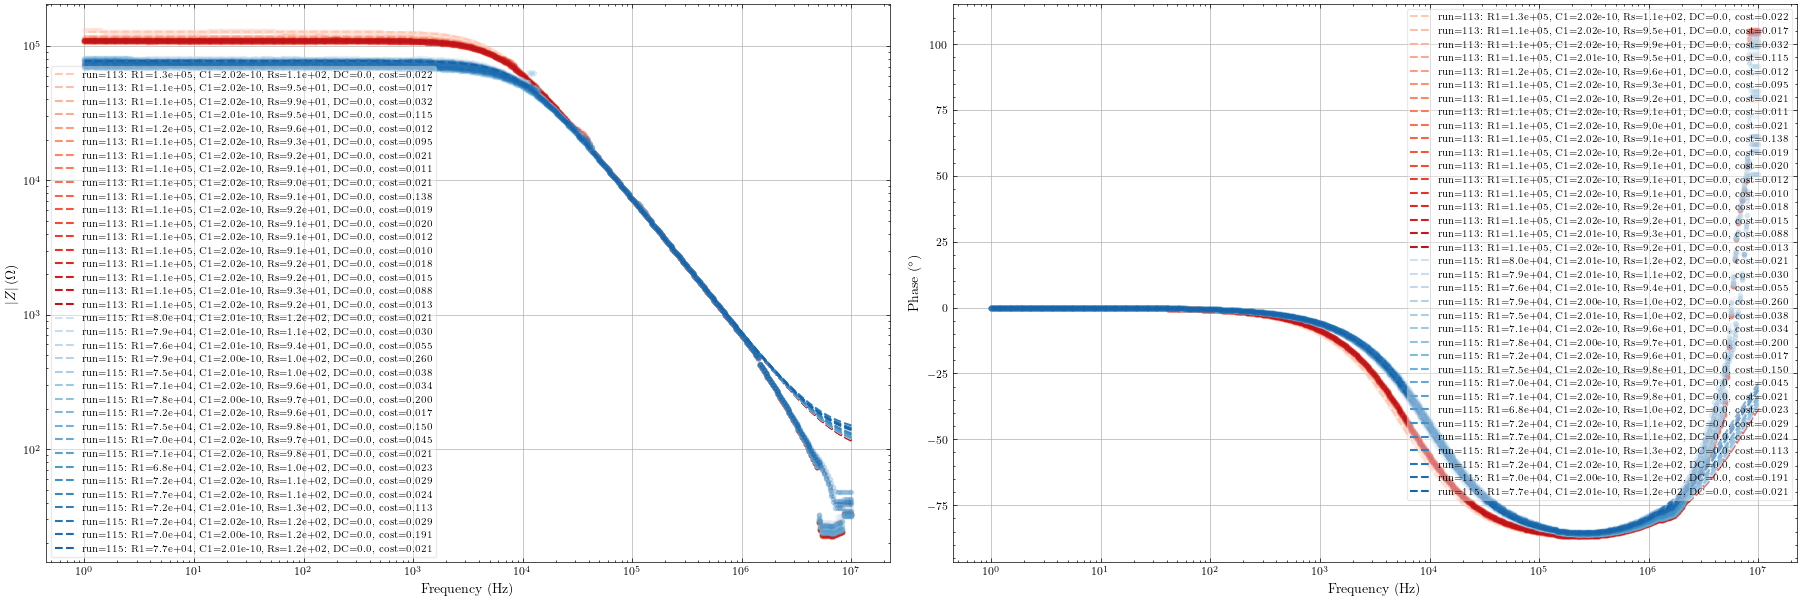

In [19]:
# ---------------------------------------- Plotting the Fitting ------------------------------
# Set Test Data
d_vac_set_test = solatron[113][0::4]
d_amb_set_test = solatron[115][0::4]
# Reset Test Data
d_vac_reset_test = solatron[113][2::4]
d_amb_reset_test = solatron[115][2::4]
# Reset Data
d_vac_reset = solatron[113][1::4]
d_amb_reset = solatron[115][1::4]
# Set data
d_vac_set = solatron[113][3::4]
d_amb_set = solatron[115][3::4]
    

d113 = [d_vac_reset_test, d_amb_reset_test]

# Labels
#plot_labels = ['wb6, pristine, ambient', 'wb6, eformed, ambient '] # label for the legend
plot_filename = 'dcresettestambvackeykey' # name for exported figure
plot_title = 'DC = 0V Post RESET (2.5V) Ambient vs Vacuum' # title for powerpoint

# Notes
notes = ['vacuum in red, ambient in blue', 'Lower resistivity in ambient', 'Identical capacitance in ambient' ] # notes for the powerpoint in text box

# if export true, update the plot string
#d113 = update_plot_string(d113, export_data=export_data, plot_labels=plot_labels)

# Plot
fig, ax = IS_plot_fit(d113, d_type='Zabsphi', freq_lim=[1e-3, 1e7], y_lim_left=None,
                    sort_data=False,  fig_size=[9,6], med_filt = 9, show_key = True)

# append the figure and title to the list for later exporting
fig_list.append((fig, plot_filename, plot_title, notes)) 

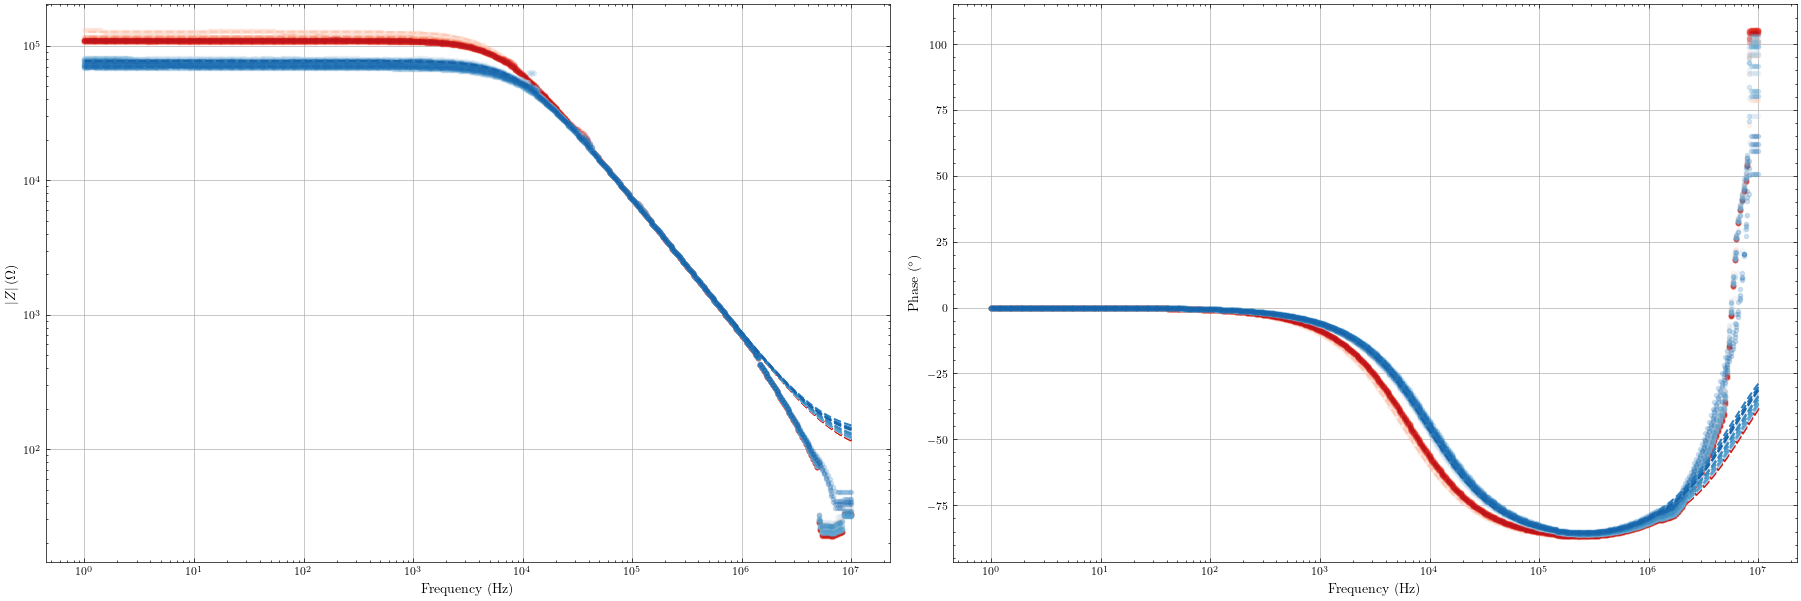

In [20]:
# ---------------------------------------- Plotting the Fitting ------------------------------
# Set Test Data
d_vac_set_test = solatron[113][0::4]
d_amb_set_test = solatron[115][0::4]
# Reset Test Data
d_vac_reset_test = solatron[113][2::4]
d_amb_reset_test = solatron[115][2::4]
# Reset Data
d_vac_reset = solatron[113][1::4]
d_amb_reset = solatron[115][1::4]
# Set data
d_vac_set = solatron[113][3::4]
d_amb_set = solatron[115][3::4]
    

d113 = [d_vac_reset_test, d_amb_reset_test]

# Labels
#plot_labels = ['wb6, pristine, ambient', 'wb6, eformed, ambient '] # label for the legend
plot_filename = 'dcresettestambvacnokey' # name for exported figure
plot_title = 'DC = 0V Post RESET (2.5V) Ambient vs Vacuum' # title for powerpoint

# Notes
notes = ['vacuum in red, ambient in blue', 'Lower resistivity in ambient', 'Identical capacitance in ambient' ] # notes for the powerpoint in text box

# if export true, update the plot string
#d113 = update_plot_string(d113, export_data=export_data, plot_labels=plot_labels)

# Plot
fig, ax = IS_plot_fit(d113, d_type='Zabsphi', freq_lim=[1e-3, 1e7], y_lim_left=None,
                    sort_data=False,  fig_size=fig_size, med_filt = 9, show_key = False)

# append the figure and title to the list for later exporting
fig_list.append((fig, plot_filename, plot_title, notes)) 

# Plots of R vs C etc

/var/folders/xr/wc8tnsks36n8ywxxvqplwqch0000gn/T/ipykernel_18980/1525611538.py:33: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax_r.boxplot(r_data, labels=box_labels)
/var/folders/xr/wc8tnsks36n8ywxxvqplwqch0000gn/T/ipykernel_18980/1525611538.py:40: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax_c.boxplot(c_data, labels=box_labels)


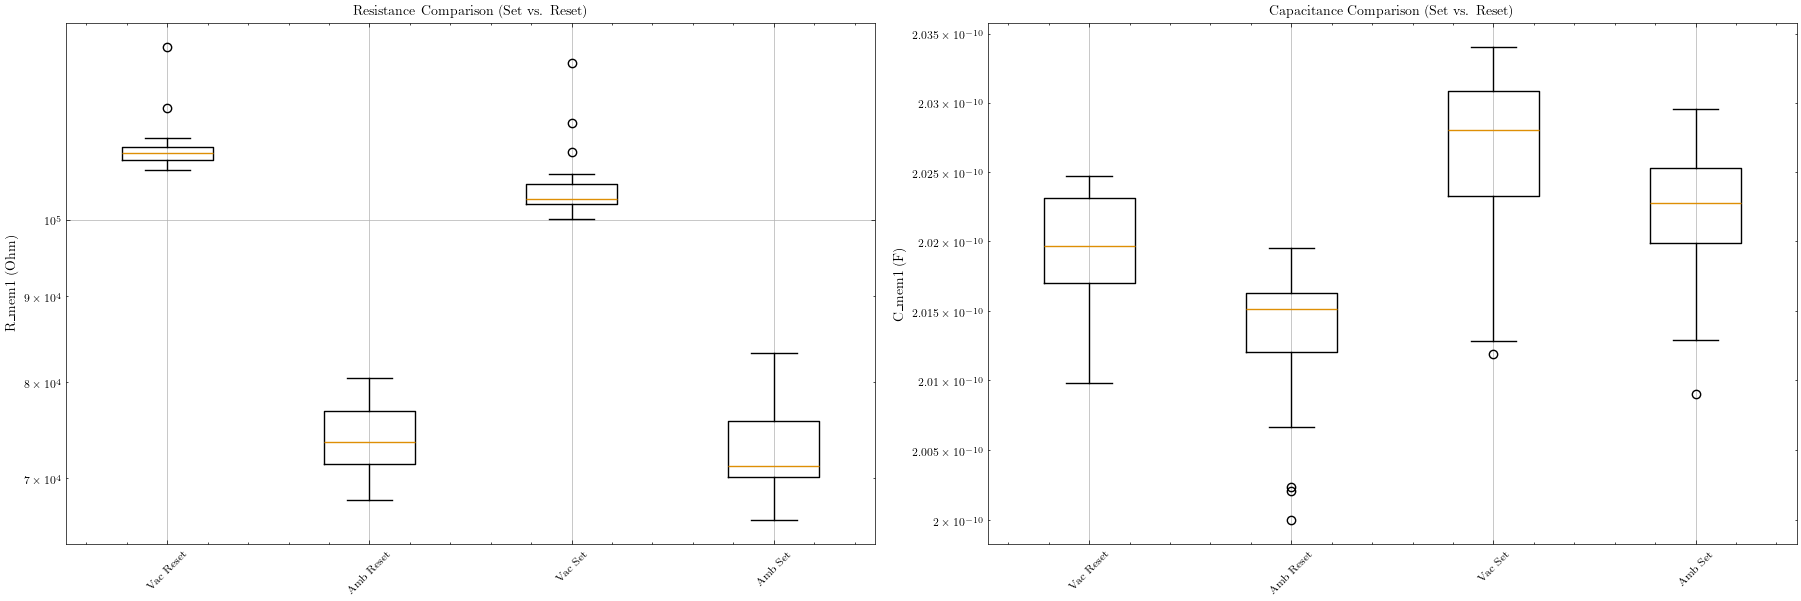

In [21]:
# Helper function to extract parameters
def extract_param_values(data_group, param_name):
    values = []
    for measurement in data_group:
        if hasattr(measurement, 'Z_parameters') and measurement.Z_parameters is not None:
            params = measurement.Z_parameters
            if params.get(param_name) is not None:
                values.append(params[param_name])
    return values

# Extract R_mem1 values
r_vac_reset = extract_param_values(d_vac_reset_test, 'R_mem1')
r_amb_reset = extract_param_values(d_amb_reset_test, 'R_mem1')
r_vac_set = extract_param_values(d_vac_set_test[1:], 'R_mem1')
r_amb_set = extract_param_values(d_amb_set_test[1:], 'R_mem1')

# Extract C_mem1 values
c_vac_reset = extract_param_values(d_vac_reset_test, 'C_mem1')
c_amb_reset = extract_param_values(d_amb_reset_test, 'C_mem1')
c_vac_set = extract_param_values(d_vac_set_test[1:], 'C_mem1')
c_amb_set = extract_param_values(d_amb_set_test[1:], 'C_mem1')

# Data for boxplots
r_data = [r_vac_reset, r_amb_reset, r_vac_set, r_amb_set]
c_data = [c_vac_reset, c_amb_reset, c_vac_set, c_amb_set]
box_labels = ['Vac Reset', 'Amb Reset', 'Vac Set', 'Amb Set']
plot_size = [fig_size[0]*2, fig_size[1]*1]

# Create a single figure with two subplots side by side
fig, (ax_r, ax_c) = plt.subplots(1, 2, figsize=plot_size, constrained_layout=True)

# Resistance boxplot
ax_r.boxplot(r_data, labels=box_labels)
ax_r.set_ylabel('R_mem1 (Ohm)')
ax_r.set_title('Resistance Comparison (Set vs. Reset)')
ax_r.set_yscale('log')
ax_r.tick_params(axis='x', rotation=45)

# Capacitance boxplot
ax_c.boxplot(c_data, labels=box_labels)
ax_c.set_ylabel('C_mem1 (F)')
ax_c.set_title('Capacitance Comparison (Set vs. Reset)')
ax_c.set_yscale('log')
ax_c.tick_params(axis='x', rotation=45)

# Show the combined plot
plt.show()

# Labels for export
plot_filename = 'capnrescomp_boxplot' # name for exported figure
plot_title = 'Resistance and Capacitance Comparison (Box Plot)' # title for powerpoint
notes = ['Box plots comparing resistance and capacitance for SET and RESET states in vacuum and ambient conditions.'] # notes for the powerpoint in text box

# append the figure and title to the list for later exporting
fig_list.append((fig, plot_filename, plot_title, notes))

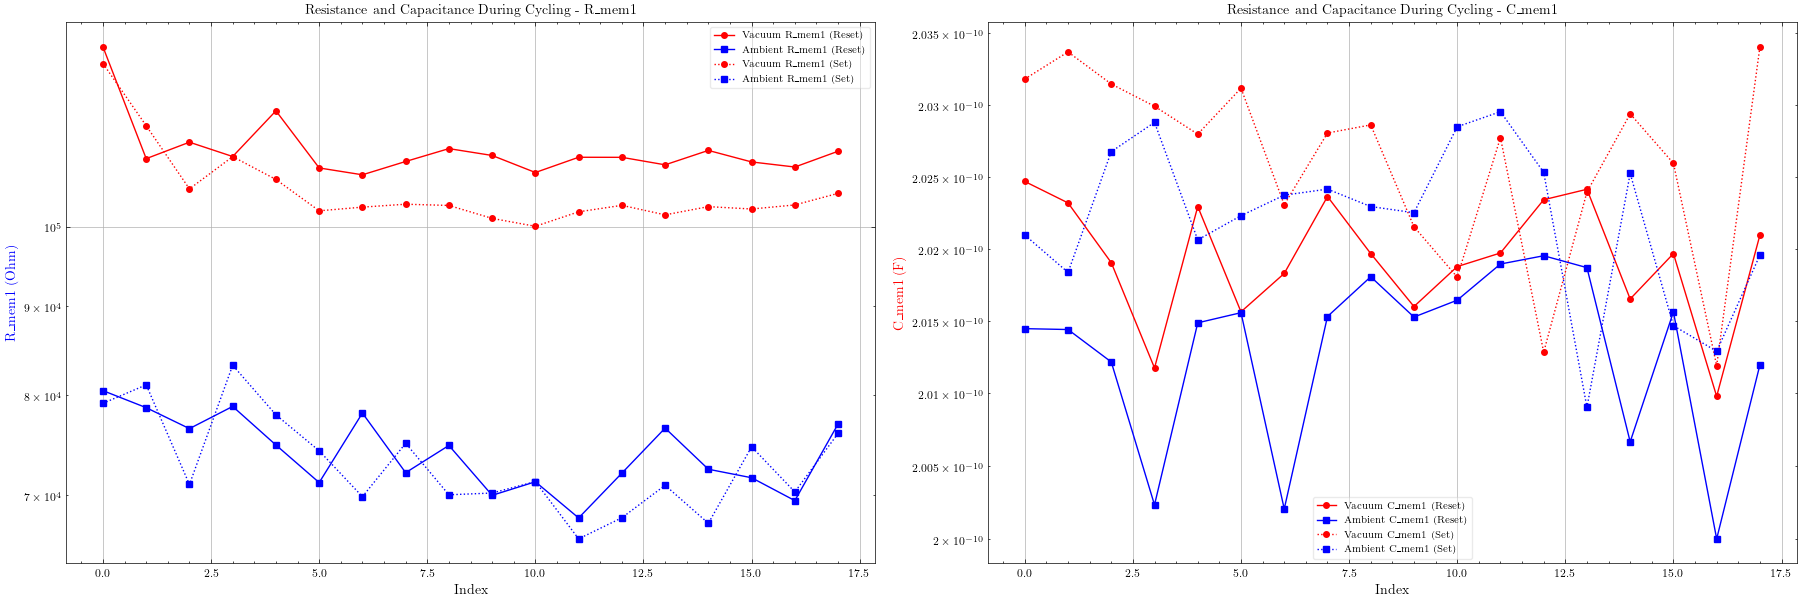

In [22]:
# Define colors and markers
colors = ['red', 'blue']  # Vacuum in red, Ambient in blue
markers = ['o', 's']  # Example markers for vacuum and ambient
labels = ['Vacuum', 'Ambient']  # Labels for the legend
plot_size = [fig_size[0]*2, fig_size[1]*1]  # Adjust plot size for better visibility


title = 'Resistance and Capacitance During Cycling'  # Title for the plot

# Create a single figure with two subplots side by side
fig, (ax_r, ax_c) = plt.subplots(1, 2, figsize=plot_size, constrained_layout=True)


# Process each group for R_mem1
for i, data_group in enumerate([d_vac_reset_test, d_amb_reset_test]):
    r_mem_values = []
    indices = []
    
    for j, measurement in enumerate(data_group):
        if hasattr(measurement, 'Z_parameters') and measurement.Z_parameters is not None:
            params = measurement.Z_parameters
            if params.get('R_mem1') is not None:
                r_mem_values.append(params['R_mem1'])
                indices.append(j)
    
    # Plot R_mem1
    ax_r.plot(indices, r_mem_values, color=colors[i], marker=markers[i], 
              linestyle='-', label=f'{labels[i]} R_mem1 (Reset)')

# Add data for d_vac_set_test and d_amb_set_test with dotted lines
for i, data_group in enumerate([d_vac_set_test[1:], d_amb_set_test[1:]]):
    r_mem_values = []
    indices = []
    
    for j, measurement in enumerate(data_group):
        if hasattr(measurement, 'Z_parameters') and measurement.Z_parameters is not None:
            params = measurement.Z_parameters
            if params.get('R_mem1') is not None:
                r_mem_values.append(params['R_mem1'])
                indices.append(j)
    
    # Plot R_mem1
    ax_r.plot(indices, r_mem_values, color=colors[i], marker=markers[i], 
              linestyle=':', label=f'{labels[i]} R_mem1 (Set)')

# Set labels, title, and scale for R_mem1
ax_r.set_xlabel('Index')
ax_r.set_ylabel('R_mem1 (Ohm)', color='blue')
ax_r.set_title(f'{title} - R_mem1')
ax_r.set_yscale('log')
ax_r.legend(loc='best')

# Process each group for C_mem1
for i, data_group in enumerate([d_vac_reset_test, d_amb_reset_test]):
    c_mem_values = []
    indices = []
    
    for j, measurement in enumerate(data_group):
        if hasattr(measurement, 'Z_parameters') and measurement.Z_parameters is not None:
            params = measurement.Z_parameters
            if params.get('C_mem1') is not None:
                c_mem_values.append(params['C_mem1'])
                indices.append(j)
    
    # Plot C_mem1
    ax_c.plot(indices, c_mem_values, color=colors[i], marker=markers[i], 
              linestyle='-', label=f'{labels[i]} C_mem1 (Reset)')

# Add data for d_vac_set_test and d_amb_set_test with dotted lines
for i, data_group in enumerate([d_vac_set_test[1:], d_amb_set_test[1:]]):
    c_mem_values = []
    indices = []
    
    for j, measurement in enumerate(data_group):
        if hasattr(measurement, 'Z_parameters') and measurement.Z_parameters is not None:
            params = measurement.Z_parameters
            if params.get('C_mem1') is not None:
                c_mem_values.append(params['C_mem1'])
                indices.append(j)
    
    # Plot C_mem1
    ax_c.plot(indices, c_mem_values, color=colors[i], marker=markers[i], 
              linestyle=':', label=f'{labels[i]} C_mem1 (Set)')

# Set labels, title, and scale for C_mem1
ax_c.set_xlabel('Index')
ax_c.set_ylabel('C_mem1 (F)', color='red')
ax_c.set_title(f'{title} - C_mem1')
ax_c.set_yscale('log')
ax_c.legend(loc='best')

# Show the combined plot
plt.show()



# Labels
#plot_labels = ['wb6, pristine, ambient', 'wb6, eformed, ambient '] # label for the legend
plot_filename = 'capnrescomp' # name for exported figure
plot_title = 'Resistance and Capacitance During Cycling' # title for powerpoint

# Notes
notes = ['' ] # notes for the powerpoint in text box

# if export true, update the plot string
#d113 = update_plot_string(d113, export_data=export_data, plot_labels=plot_labels)


# append the figure and title to the list for later exporting
fig_list.append((fig, plot_filename, plot_title, notes)) 



--- Starting Fit for: run=100, DC=0, V_rms=0.01, p, vacuum, noamp, wirebond5 ---
Using model: RC
With fixed params: {'C_pad': 1.9147705850766482e-11}
Frequency range: (0.1, 1000000.0)
Free parameters to fit: ['R_mem1', 'C_mem1', 'R_series']
301 pts post-freq filter.
Median filter k=5
Running DE...
DE OK.
 DE Final Cost: 6.2899e+02
  DE Best:)
name R_mem1: 8.38e+13
name C_mem1: 1.00e-08
name R_series: 7.51e+02

Running LS Refinement...
LS OK!
  LS Final Cost: 317.431
  Final Fitted Parameters:
    R_mem1: 83815267488315.938
    C_mem1: 0.000
    C_pad: 0.000
    R_series: 750.775
--- Fit finished for: run=100, DC=0, V_rms=0.01, p, vacuum, noamp, wirebond5 ---

--- Starting Fit for: run=100, DC=0, V_rms=0.01, p, vacuum, noamp, wirebond5 ---
Using model: RC
With fixed params: {'C_pad': 1.9147705850766482e-11}
Frequency range: (0.1, 1000000.0)
Free parameters to fit: ['R_mem1', 'C_mem1', 'R_series']
301 pts post-freq filter.
Median filter k=5
Running DE...
DE OK.
 DE Final Cost: 6.3607e+0

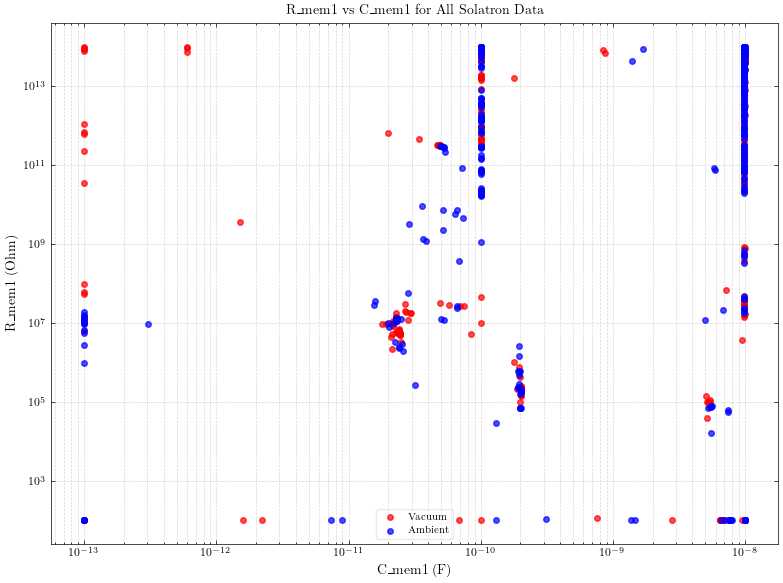

<Figure size 900x600 with 0 Axes>

In [23]:
# Fit all Solatron data and plot R_mem1 vs C_mem1, colored by environment (vacuum/ambient)

# --- Settings for fitting ---
fit_settings = {
    'model_type': 'RC',  # Use RC model for all fits (adjust if needed)
    'freq_bounds': (1e-1, 1e6),
    'med_filt': 5,
    'fixed_params': {'C_pad': C_calc_pad},
    'use_de': True,  # Use least squares for speed; set True for DE if needed
    'plot_fit': False,
    'fig_size': fig_size,
    'plot_type': 'Zabsphi',
    'de_bounds_dict': {'R_mem1': (1e2, 1e14), 'C_mem1': (1e-13, 1e-8), 'C_pad': (1e-11, 3e-11), 'R_series': (1, 1e4)},
    'ls_bounds_dict': {'R_mem1': (1e2, 1e14), 'C_mem1': (1e-13, 1e-8), 'C_pad': (1e-11, 3e-11), 'R_series': (1, 1e4)},
    'de_maxiter': 1000,
    'ls_max_nfev': 10000,
    'de_popsize': 20,
    'de_tol': 1e-5,
    'ls_ftol': 1e-13,
    'ls_xtol': 1e-13,
    'ls_gtol': 1e-13,
}

# Helper to fit a list of ISdata objects
def fit_all(data_list, fit_settings):
    for dat in data_list:
        try:
            fit_impedance_data(dat, **fit_settings)
        except Exception as e:
            print(f"Fit failed: {e}")

# Gather all measurements for vacuum and ambient using vac_state
vacuum_data = []
ambient_data = []
for run in solatron:
    for m in solatron[run]:
        vac_state = getattr(m, 'vac_state', None)
        if vac_state is not None:
            if vac_state.lower() in ['vacuum', 'vac']:
                vacuum_data.append(m)
            elif vac_state.lower() == 'ambient':
                ambient_data.append(m)

# Fit all data
fit_all(vacuum_data, fit_settings)
fit_all(ambient_data, fit_settings)

# Extract R_mem1 and C_mem1 for each measurement
def extract_R_C(data_list):
    R, C = [], []
    for m in data_list:
        params = getattr(m, 'Z_parameters', None)
        if params is not None and 'R_mem1' in params and 'C_mem1' in params:
            R.append(params['R_mem1'])
            C.append(params['C_mem1'])
    return np.array(R), np.array(C)

R_vac, C_vac = extract_R_C(vacuum_data)
R_amb, C_amb = extract_R_C(ambient_data)

# Plot R vs C
plt.figure(figsize=[8,6])
plt.scatter(C_vac, R_vac, color='red', label='Vacuum', alpha=0.7)
plt.scatter(C_amb, R_amb, color='blue', label='Ambient', alpha=0.7)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('C_mem1 (F)')
plt.ylabel('R_mem1 (Ohm)')
plt.title('R_mem1 vs C_mem1 for All Solatron Data')
plt.legend()
plt.grid(True, which='both', ls='--', alpha=0.5)
plt.tight_layout()
plt.show()

# Optionally, append to fig_list for export
fig = plt.gcf()
plot_filename = 'R_vs_C_ambient_vacuum'
plot_title = 'R vs C for All Solatron Data'
notes = ['Red: Vacuum, Blue: Ambient. Each point is a fitted measurement.']
fig_list.append((fig, plot_filename, plot_title, notes))


In [24]:
25e-9/((20e-6)**2 *2.46e-4)
print( 9e-9 *25e-9/((20e-6)**2 *epsilon_0))

63529.25999668198


# Exporting

### Exporting All Figures as Individual Files

In [25]:
if export_data:
    for fig_obj, fig_name, fig_title, notes in fig_list:
        save_path = Path(output_IS_solatron) / Path(f"{fig_name}_{powerpoint_string}.{fig_format}")
        fig_obj.savefig(save_path, dpi=600, bbox_inches='tight', transparent=plot_transparency)

### Exporting to Powerpoint

In [26]:
if export_data == True:
    # Create a PowerPoint presentation object
    prs = Presentation()
    # Set slide dimensions to 16:9 widescreen (13.333 x 7.5 inches)
    [prs.slide_width, prs.slide_height] = [Inches(13.333), Inches(7.5)]
   
    # define the path to the output directory
    path_out = output_IS_solatron

    # Add each figure to the PowerPoint presentation if it exists
    for fig, fig_name, title, notes in fig_list:
        add_slide(fig, title, notes, prs, path_out = path_out, layout='vertical')

    # Save the PowerPoint presentation
    prs.save(Path(path_out) / Path(f'{powerpoint_string}.pptx'))